In [ ]:
# Import necessary libraries
import pandas as pd
import time
import re
import string
from fuzzywuzzy import fuzz, process
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import openpyxl
import pickle
from bs4 import BeautifulSoup
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import inflect
from typing import List, Dict, Optional, Tuple, Set, Any, Union
from collections import Counter, defaultdict
from itertools import combinations
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from dataclasses import dataclass, field
import logging
from functools import wraps
import ast
import gc
from datetime import datetime
import warnings
import traceback
warnings.filterwarnings('ignore')

/Users/buse/miniforge3/envs/ml_env/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# 1. Web Scraping (Brand Names and Description)

In this section, I developed a web scraping tool to gather brand names and descriptions directly from the Mondelez website. 

### Objective
The goal of this step is to extract relevant information about each brand under Mondelez, providing a structured dataset of brand names and their associated descriptions. This will help us fill in missing brand information in the data provided by KKR and facilitate further analysis.

### Methodology
1. **Setting Up the Scraper**: I created a Python class called `MondelezScraper` to encapsulate the web scraping process, making the code organized and reusable.
   - The class initializes with essential parameters like the base URL of Mondelez’s website and HTTP headers to mimic a browser, which helps avoid being blocked by the website.
   
2. **Identifying Brand Elements**: By inspecting the HTML structure of Mondelez’s "Our Brands" page, I identified two key CSS selectors:
   - `.brand-card` and `.profileCardWrapper`
   - These CSS selectors are used because they specifically target the HTML elements that contain brand names and links to their detailed pages. This step ensures that we’re scraping only relevant brand-related information.
   
3. **Extracting Brand Descriptions**: For each brand link, I used a function that:
   - Visits the individual brand page.
   - Attempts to locate a detailed description using various CSS selectors (`.brand-description`, `.main-content p`, etc.) to handle any variations in page layout.
   - Cleans up the text by removing extra whitespace and only keeping meaningful content.
   
4. **Data Storage**: The scraped data is stored in a `DataFrame` for easy processing. I saved this information into a CSV file (`mondelez_brands.csv`), which can be used directly for data analysis or as a backup for any missing information.

### Challenges and Improvements
- **Challenges**: Web scraping relies on the structure of the website. If Mondelez updates its website layout, some CSS selectors might break.
- **Possible Improvements**: Adding dynamic selectors or using an API (if available) would make this process more robust and less dependent on a fixed HTML structure.

---

This step enables us to collect essential brand data, forming a strong foundation for further analysis. With the structured data on each brand, we can better analyze brand performance and customer retention for KKR.


In [4]:
class MondelezScraper:
    def __init__(self):
        '''
        Initializes the MondelezScraper class.
        Sets the base URL, headers for HTTP requests, and an empty list to store brand data.
        '''
        self.base_url = 'https://www.mondelezinternational.com'
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        self.brand_data = []

    def clean_text(self, text):
        '''
        Cleans the provided text by removing extra whitespace and newlines.
        Args:
            text (str): The text to be cleaned.
        Returns:
            str: The cleaned text.
        '''
        if text:
            # Remove extra whitespace and newlines
            text = re.sub(r'\s+', ' ', text).strip()
            return text
        return ""

    def get_brand_details(self, brand_url):
        '''
        Fetches the details of a brand by scraping its page.
        Args:
            brand_url (str): The URL of the brand page to scrape.
        Returns:
            str: The brand description or an error message if scraping fails.
        '''
        try:
            response = requests.get(brand_url, headers=self.headers)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                
                # Try different selectors for description
                description = None
                possible_selectors = [
                    '.brand-description',
                    '.description',
                    '.content-wrapper p',
                    '.main-content p',
                    '[data-content-type="text"]',
                    'p em',  # For italicized brand name
                    'p',     # For regular paragraphs
                    '.row p' # For paragraphs within row class
                ]

                for selector in possible_selectors:
                    elements = soup.select(selector)
                    if elements:
                        # Filter out very short texts and combine meaningful paragraphs
                        meaningful_texts = []
                        for elem in elements:
                            text = elem.get_text(strip=True)
                            # Only include text that's longer than 50 characters
                            if len(text) > 50:
                                meaningful_texts.append(text)
                        
                        if meaningful_texts:
                            description = ' '.join(meaningful_texts)
                            break

                return description if description else "Description not found"

            return f"Failed to retrieve content: Status code {response.status_code}"
        
        except Exception as e:
            return f"Error occurred: {str(e)}"

    def scrape_brands(self):
        '''
        Scrapes all brands listed on the Mondelez 'Our Brands' page.
        Retrieves brand names and descriptions, saves them to CSV and Excel files, and displays them.
        Returns:
            DataFrame: A pandas DataFrame containing the scraped brand data.
        '''
        brands_url = f"{self.base_url}/our-brands"
        
        try:
            response = requests.get(brands_url, headers=self.headers)
            if response.status_code != 200:
                print(f"Failed to access brands page: Status code {response.status_code}")
                return

            soup = BeautifulSoup(response.content, 'html.parser')
            brand_elements = soup.select('.brand-card, .profileCardWrapper')

            # Remove the invalid text from here
            total_brands = len(brand_elements)
            print(f"Found {total_brands} brands to scrape")

            for index, brand_element in enumerate(brand_elements, 1):
                link = brand_element.find('a')
                if link:
                    brand_name = link.get_text(strip=True)
                    brand_url = link.get('href')
                    if brand_url:
                        if not brand_url.startswith('http'):
                            brand_url = self.base_url + brand_url

                        print(f"[{index}/{total_brands}] Scraping {brand_name}...")
                        description = self.get_brand_details(brand_url)
                        description = self.clean_text(description)
                        
                        self.brand_data.append({
                            'brand_name': brand_name,
                            'brand_description': description
                        })

                        # Add a delay between requests
                        time.sleep(2)

            # Convert to DataFrame
            df = pd.DataFrame(self.brand_data)
            
            # Save to CSV
            df.to_csv('mondelez_brands.csv', index=False)
            
            print("\nScraping completed! Results saved to CSV and Excel files")
            
            # Display all brands and descriptions
            pd.set_option('display.max_colwidth', None)
            print("\nAll Brands and Descriptions:")
            print(df)
            
            return df

        except Exception as e:
            print(f"An error occurred: {str(e)}")
            return None

In [24]:
# Run the scraper
if __name__ == "__main__":
    '''
    Creates an instance of MondelezScraper and initiates the scraping process.
    '''
    scraper = MondelezScraper()
    brands_df = scraper.scrape_brands()

Found 42 brands to scrape
[1/42] Scraping 5 STAR...
[2/42] Scraping 7DAYS...
[3/42] Scraping ALPEN GOLD...
[4/42] Scraping BARNI...
[5/42] Scraping BELVITA...
[6/42] Scraping B0URNVITA...
[7/42] Scraping CADBURY...
[8/42] Scraping CADBURY DAIRY MILK...
[9/42] Scraping CHIPS AHOY!...
[10/42] Scraping CLIF...
[11/42] Scraping CLORETS...
[12/42] Scraping CLUB SOCIAL...
[13/42] Scraping CôTE D'OR...
[14/42] Scraping DAIM...
[15/42] Scraping ENJOY LIFE FOODS...
[16/42] Scraping FREIA...
[17/42] Scraping GRENADE...
[18/42] Scraping HALLS...
[19/42] Scraping HONEY MAID...
[20/42] Scraping HU...
[21/42] Scraping KINH DO...
[22/42] Scraping LACTA...
[23/42] Scraping LU...
[24/42] Scraping MARABOU...
[25/42] Scraping MAYNARDS BASSETT'S...
[26/42] Scraping MIKADO...
[27/42] Scraping MILKA...
[28/42] Scraping OREO...
[29/42] Scraping PERFECT SNACKS...
[30/42] Scraping PHILADELPHIA...
[31/42] Scraping PRINCE...
[32/42] Scraping RITZ...
[33/42] Scraping ROYAL...
[34/42] Scraping SOUR PATCH KIDS...
[

# 2. Matching Brands with Nulls in Receipt Data


### Objective

The purpose of this section is to match brands in receipt data where the brand information is missing. Using the preprocessed brand list from the scraped data, I aim to fill in these nulls as accurately as possible, which is crucial for subsequent analysis, such as customer retention and brand overlap studies.

---

### Methodology

#### 1. Data Preprocessing
 **Brand Name Processing**:
* Advanced abbreviation handling ('intl' → 'international')
* Plural/singular variations using inflect engine
* Brand-specific patterns ("Oreo's" → "oreo")
* Special character preservation
* Standardization of common variations

 **Brand Variations**:
* Dictionary of known variations
* Common misspellings and alternative forms 
* Compound brand names ("Chips Ahoy!" → {"chips ahoy", "chipsahoy"})
* Multi-word brand n-grams

 **Description Text**:
* Standardized measurements ("2 ounces" → "2oz")
* Package sizes ("family size", "party pack")
* Product variations ("sugar free" → "sugarfree")
* NLTK lemmatization
* Consistent abbreviation expansion




---

#### 2. Brand Matching Process

- **BrandMatcher Class**: This class matches the standardized brand data with items in the receipt data. For items with missing brand information, it attempts to find exact matches in the brand list. If no exact match is found, the item is left unmatched.
  
- **Standardizing Manufacturer Names**: Within the `BrandMatcher`, there is a method called `_standardize_manufacturer` that standardizes various versions of Mondelez manufacturer names to a single format. This helps reduce discrepancies caused by slight variations in naming conventions.

---

#### 3. Avoidance of Fuzzy Matching

Due to the noisy nature of the data, fuzzy matching was avoided to prevent incorrect matches. For example, using fuzzy matching could misinterpret unrelated words (e.g., "leggings" or other non-food items) as brands, leading to false positives. Instead, exact matches and controlled pattern-based matching are used to prioritize accuracy.

---

#### 4. Enhanced Matching Using Patterns

- **DetailedHybridMatcher Class**: This class builds on the `BrandMatcher` by learning from high-confidence matches. It identifies patterns such as context words, brand co-occurrences, and size/package terms from high-confidence matches, improving recognition for complex cases.

- **Pattern Learning and Validation**: By analyzing patterns from confirmed matches, the `DetailedHybridMatcher` identifies brand names within specific product contexts. It also includes validation steps to prevent false positives by ensuring descriptions align with known brand contexts.

---

### 5. ComprehensiveNonMatchAnalyzer Class

This class, `ComprehensiveNonMatchAnalyzer`, identifies and categorizes items in the receipt data that are either non-food items or have no textual similarity to Mondelez brands. By using indicators like category-specific terms (e.g., clothing-related words), size patterns, and other non-food keywords, it effectively filters out irrelevant data. This process helps reduce false positives in the brand-matching process by eliminating items that either clearly don’t relate to food or show no textual similarity to Mondelez brand names.

### Potential Improvements

1. **Automated NLP Techniques**:
   - In a real-world scenario, more automated natural language processing (NLP) methods could be implemented to improve the precision of brand matching.
   - Techniques such as entity recognition or context-based similarity scoring could enhance the accuracy of matches without relying solely on exact string matches.

2. **Confidence Scoring and Thresholds**:
   - While there is a confidence scoring system (0-100) based on different match types (exact, manufacturer-based, learned patterns), more granular confidence tiers could be used.
   - Setting different confidence thresholds for automated and manual checks would allow high-confidence matches to be accepted automatically, while lower-confidence matches could be flagged for review.

3. **Improved Pattern Learning**:
   - Additional pattern learning, such as better handling of abbreviations, unit measurements, and singular/plural forms, could be beneficial.
   - By refining patterns around keywords and brand combinations, we can capture more relevant matches while reducing false positives.

4. **Cross-Validation**:
   - Adding cross-validation checks, such as matching price ranges or package sizes, would provide extra assurance that our matched brands align with expected values.
   - Historical pattern validation and comparing matches across different methods could further enhance confidence in results.

5. **Error Tracking and Quality Control**:
   - Implementing an error categorization system for unmatched or potentially incorrect matches would improve error analysis.
   - Establishing feedback loops and manual review mechanisms would allow for continuous improvement in matching quality.

---

### Challenges and Limitations

1. **Noisy Data**:
   - Many descriptions contain extraneous information (e.g., "leggings" or non-food-related terms) that increases the risk of false positives. To mitigate this, I focused on exact matches and patterns rather than fuzzy matching.
   
2. **Manual Workload**:
   - Due to the complexity of brand data, some manual oversight was necessary to ensure accuracy. A fully automated system would need additional layers of checks and validations, which may require significant setup time.

3. **Potential Discrepancies**:
   - Some matches may still contain discrepancies due to slight variations in brand names or ambiguous descriptions. For example, "Cadbury Dairy Milk" may be spelled differently or include unrelated terms.
   - To address this in future iterations, a feedback system could be incorporated to refine matches continuously based on discrepancies noted during analysis.

---

### Key Achievements and Improvements

1. **Confidence Scoring**:
   - A confidence scoring system was established, with match types (exact, manufacturer-based, learned pattern) each contributing to a total confidence score from 0-100.
   - Weighted scores were applied based on criteria like keyword matches, context, and brand co-occurrence, allowing for better match validation.

2. **Pattern Learning**:
   - High-confidence matches were used to learn patterns, including context words, size, and package types, as well as common brand combinations.
   - These learned patterns improved the accuracy of matching descriptions with ambiguous or partially matched brand information.

3. **Validation Rules**:
   - Comprehensive validation rules were implemented to reduce errors, such as thresholds for required matches and non-food rejection criteria.
   - Multi-factor scoring for keywords, context, and descriptive terms added further robustness to the matching process.

---

### Remaining Gaps and Future Improvements

Given more time, we could incorporate several advanced NLP techniques to make the brand matching process more accurate, flexible, and automated. These techniques would minimize manual intervention and handle complex cases more effectively.

#### Advanced NLP Techniques for Improved Brand Matching

- **Named Entity Recognition (NER)**:
  - **Explanation**: NER can identify and categorize brand names in product descriptions. By training an NER model specifically on brand data, we could better detect Mondelez brands even when descriptions are complex or non-standard.
  - **Advantage**: This would capture brand references that don’t exactly match predefined names but still clearly refer to Mondelez products, reducing the need for manual input on ambiguous items.

- **Contextual Word Embeddings (e.g., BERT)**:
  - **Explanation**: Embedding models like BERT or GPT capture word meanings in context. Using these models allows the system to recognize brand names even when embedded in varied or unusual phrases.
  - **Advantage**: This would reduce false positives by understanding whether a brand is genuinely referenced or if the word is used in a different context, leading to more accurate matches without manual adjustments.

- **Semantic Similarity Scoring with Embeddings**:
  - **Explanation**: NLP-based similarity scoring (e.g., cosine similarity on embeddings) could assess the semantic closeness of product descriptions to known brand descriptions. This would allow matches based on meaning rather than exact wording.
  - **Advantage**: Improves flexibility in detecting brand names in varied descriptions (e.g., “Oreo Choco” matching “Chocolate Oreo”) while avoiding unrelated matches.

- **Text Classification Models for Product Categorization**:
  - **Explanation**: A trained classification model could categorize items into specific product types (e.g., snacks, beverages) based on their descriptions. This categorization could then be cross-referenced with the expected brand categories to validate matches.
  - **Advantage**: Adds another layer of automated validation by ensuring that matched brands fit logically within product categories, reducing misclassifications.

- **Automated Pattern Learning with Topic Modeling**:
  - **Explanation**: Topic modeling (e.g., using Latent Dirichlet Allocation, LDA) could identify recurring themes or patterns in product descriptions. These learned patterns could help detect new or ambiguous brands that frequently appear with Mondelez terms.
  - **Advantage**: Allows the system to adapt automatically by learning from product descriptions, reducing the need for hard-coded brand lists and manual updates.

---

### Standardized, Automated Feedback and Manual Review Mechanisms

To improve the system over time, implementing a structured feedback loop would allow for continuous refinement of the brand-matching process. This could be achieved through automated flagging, confidence scoring, and manual review processes.

- **Feedback Logging for Error Patterns**:
  - **Explanation**: Implement a system to log and categorize errors based on review feedback (e.g., false positives, missed matches, non-food items). This data could then inform the NLP model and improve future iterations.
  - **Advantage**: Provides insights into recurring issues, allowing the system to be refined to address specific types of errors.

- **Confidence Threshold Tiers**:
  - **Explanation**: Implement a tiered confidence scoring system where matches are processed differently based on their confidence level. High-confidence matches can be automated, mid-level confidence matches flagged for review, and low-confidence matches rejected.
  - **Advantage**: Improves efficiency by automating only the most reliable matches while ensuring that uncertain cases are checked by human reviewers.

- **Iterative Model Training with Feedback**:
  - **Explanation**: Use the feedback from manual reviews to iteratively retrain the NLP models, focusing on misclassifications or areas with high false positive rates.
  - **Advantage**: Enables continuous learning, allowing the system to become more accurate over time with less manual intervention as the models improve from feedback.

---

### Enhanced Handling of Edge Cases with NLP

Edge cases, such as variety packs, promotional items, and seasonal editions, often present challenges in brand detection. NLP models and automated handling can improve accuracy in these cases.

- **Detection of Variety Packs and Mixed Bundles**:
  - **Explanation**: Use multi-label classification or sequence tagging to identify variety packs that mention multiple brands. An NLP model could identify that a description includes multiple Mondelez brands and categorize the item accordingly.
  - **Advantage**: Improves handling of complex product descriptions where multiple brands are mentioned, reducing partial or incorrect matches.

- **Seasonal and Promotional Items Recognition**:
  - **Explanation**: Train NLP models to detect seasonal or promotional keywords (e.g., “holiday edition,” “limited time”) that may change the product’s description temporarily.
  - **Advantage**: Prevents mismatches due to temporary product variations, ensuring consistent matching across regular and seasonal descriptions.

- **Non-Food Item Filtering**:
  - **Explanation**: Use text classification models to filter out non-food items (e.g., “Oreo-themed T-shirt”) based on key phrases and context. These items can be flagged or excluded automatically from the brand-matching process.
  - **Advantage**: Reduces the manual work required to remove non-food items from matches, avoiding false positives for Mondelez products in unrelated categories.

---

By implementing these techniques, I aimed to create a robust, adaptable matching system that balances precision and recall. While the current approach works well for this case study, expanding it with advanced NLP and more refined validation techniques would make it suitable for larger-scale analyses.


In [22]:
class BrandMatcher:
    def __init__(self, reference_brands_path: str, receipts_path: str):
        '''
        Initializes the BrandMatcher class with reference brand names and receipt data.
        '''
        try:
            self.reference_brands_df = pd.read_csv(reference_brands_path)
            self.receipts_df = pd.read_csv(receipts_path)
            
            # Verify the brand_variation column exists in reference brands
            if 'brand_variation' not in self.reference_brands_df.columns:
                raise ValueError("Missing 'brand_variation' column in reference brands file")
                
            # Normalize brand names: remove punctuation and lowercase
            self.reference_brands = set(
                self._normalize_text(brand)
                for brand in self.reference_brands_df['brand_variation']
                if pd.notna(brand)
            )
            
        except Exception as e:
            raise ValueError(f"Error loading data: {str(e)}")

    def _normalize_text(self, text: str) -> str:
        '''Normalizes text by converting to lowercase and removing punctuation.'''
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def _standardize_manufacturer(self, text: str) -> str:
        '''Standardizes Mondelez manufacturer names.'''
        if pd.isna(text):
            return None
        text = self._normalize_text(text)

        mondelez_variations = {
            'mondelez', 'mondelēz', 'mondelez international',
            'mondelez intl', 'mondelez int', 'mondelez intl inc',
            'toblerone mondelez international inc', 
            'cadbury dairy milk cadbury international ltd', 
            'clif shot mondelez international inc'
        }
        return 'mondelez international' if text in mondelez_variations else text

    def find_exact_brands(self, text: str) -> List[str]:
        '''Finds all exact brand matches in the provided text.'''
        if pd.isna(text):
            return []
        text = self._normalize_text(text)
        words = text.split()
        bigrams = [' '.join(words[i:i+2]) for i in range(len(words)-1)]
        trigrams = [' '.join(words[i:i+3]) for i in range(len(words)-2)]
        tokens = words + bigrams + trigrams
        matches = [token for token in tokens if token in self.reference_brands]
        return list(set(matches))

    def process_data(self) -> Tuple[pd.DataFrame, dict]:
        '''Processes receipt data to match manufacturers and brands.'''
        df = self.receipts_df.copy()
        df['clean_manufacturer'] = df['barcode_manufacturer'].apply(self._standardize_manufacturer)
        df['is_mondelez_manufacturer'] = df['clean_manufacturer'] == 'mondelez international'
        df['exact_brand_matches'] = df['item_description'].apply(self.find_exact_brands)
        df['has_exact_brand_match'] = df['exact_brand_matches'].apply(lambda x: len(x) > 0)
        df['num_brand_matches'] = df['exact_brand_matches'].apply(len)
        df['multiple_brand_matches'] = df['num_brand_matches'] > 1
        
        # Identify rows with null 'capture_brand'
        null_capture_brand = df['capture_brand'].isna()
        
        # Generate summary statistics
        stats = {
            'total_rows': len(df),
            'null_capture_brand': null_capture_brand.sum(),
            'mondelez_manufacturer_matches': df['is_mondelez_manufacturer'].sum(),
            'exact_brand_matches': df['has_exact_brand_match'].sum(),
            'exact_matches_in_null_capture': df[null_capture_brand & df['has_exact_brand_match']].shape[0],
            'mondelez_matches_in_null_capture': df[null_capture_brand & df['is_mondelez_manufacturer']].shape[0],
            'total_confident_matches': df[
                null_capture_brand &
                (df['is_mondelez_manufacturer'] | df['has_exact_brand_match'])
            ].shape[0],
            'entries_with_multiple_brands': df['multiple_brand_matches'].sum()
        }
        
        return df, stats

In [25]:
product_categories = {
    'chocolate': {
        'core_brands': [
            '5 STAR', 'ALPEN GOLD', 'CADBURY', 'CADBURY DAIRY MILK', 
            'CôTE D\'OR', 'DAIM', 'FREIA', 'LACTA', 'MARABOU', 'MILKA',
            'TOBLERONE', 'KINH DO'
        ],
        'keywords': ['chocolate', 'cocoa', 'praline', 'truffle', 'milk chocolate', 
                    'dark chocolate', 'chocolate bar', 'confectionery chocolate']
    },
    'cookies_biscuits': {
        'core_brands': [
            'OREO', 'CHIPS AHOY!', 'TATE\'S BAKE SHOP', 'BELVITA', 'LU', 
            'BARNI', 'MIKADO', 'PRINCE', 'HONEY MAID', 'HU', 'TIGER'
        ],
        'keywords': ['cookie', 'biscuit', 'baked', 'sandwich cookie', 'cream filled', 
                    'soft baked', 'bake shop', 'cookies', 'biscuits']
    },
    'crackers': {
        'core_brands': ['RITZ', 'TRISCUIT', 'WHEAT THINS', 'TUC', 'CLUB SOCIAL'],
        'keywords': ['cracker', 'savory', 'crispy', 'crunchy', 'saltine', 
                    'snack cracker', 'cheese cracker', 'crackers']
    },
    'gum_mints': {
        'core_brands': ['STRIDE', 'CLORETS'],
        'keywords': ['gum', 'mint', 'fresh', 'refreshing', 'chewing', 'breath', 
                    'long lasting']
    },
    'candy': {
        'core_brands': ['SOUR PATCH KIDS', 'HALLS', 'MAYNARDS BASSETT\'S'],
        'keywords': ['candy', 'sweet', 'sour', 'confectionery', 'lozenge', 'jelly', 
                    'sugar confectionery']
    },
    'beverages': {
        'core_brands': ['TANG', 'BOURNVITA'],
        'keywords': ['drink', 'beverage', 'powder', 'mix', 'liquid', 'refreshment']
    },
    'protein_bars': {
        'core_brands': ['CLIF', 'PERFECT SNACKS', 'GRENADE', 'ENJOY LIFE FOODS'],
        'keywords': ['protein', 'energy bar', 'nutrition bar', 'granola', 
                    'protein bar', 'nutritious', 'energy']
    },
    'cream_cheese': {
        'core_brands': ['PHILADELPHIA'],
        'keywords': ['cream cheese', 'spread', 'dairy spread', 'cheese']
    },
    'baked_goods': {
        'core_brands': ['7DAYS'],
        'keywords': ['croissant', 'pastry', 'baked goods', 'bakery']
    },
    'baking_ingredients': {
        'core_brands': ['ROYAL'],
        'keywords': ['baking powder', 'baking', 'ingredients', 'dessert mix']
    }
}

In [18]:
class DetailedHybridMatcher:
    def __init__(self, product_categories, base_df: pd.DataFrame):
        self.product_categories = product_categories
        self.base_df = base_df
        self.brand_to_category = {}
        for category, info in product_categories.items():
            for brand in info['core_brands']:
                self.brand_to_category[brand.lower()] = category
        
        # Initialize learned patterns
        self.learned_patterns = defaultdict(lambda: {
            'context_words': Counter(),
            'size_patterns': Counter(),
            'package_types': Counter(),
            'brand_combinations': Counter(),
            'descriptive_terms': Counter()
        })
        
        # Track statistics
        self.match_stats = {
            'total_rows': 0,
            'barcode_matches': 0,
            'exact_matches': 0,
            'multi_brand_matches': 0,
            'learned_pattern_matches': 0,
            'unmatched': 0,
            'category_matches': defaultdict(int),
            'brand_combinations': Counter()
        }
    
    def learn_from_high_confidence_matches(self, df: pd.DataFrame):
        """Learn patterns from high confidence matches"""
        high_confidence_df = df[
            (df['is_mondelez_manufacturer']) | 
            (df['has_exact_brand_match'])
        ].copy()
        
        print(f"Learning patterns from {len(high_confidence_df):,} high confidence matches...")
        
        # Process each category
        for category, info in self.product_categories.items():
            category_brands = set(brand.lower() for brand in info['core_brands'])
            base_keywords = set(kw.lower() for kw in info['keywords'])
            
            # Filter descriptions for this category
            category_mask = high_confidence_df['exact_brand_matches'].apply(
                lambda x: any(brand in category_brands for brand in x) if isinstance(x, list) else False
            )
            category_descriptions = high_confidence_df[category_mask]['item_description']
            
            patterns = self.learned_patterns[category]
            
            for desc in category_descriptions:
                if pd.isna(desc):
                    continue
                    
                desc = str(desc).lower()
                words = desc.split()
                
                # Extract size patterns
                sizes = re.findall(
                    r'\d+(\.\d+)?\s*(oz|g|lb|count|ct|pack|pieces|pc)', 
                    desc
                )
                patterns['size_patterns'].update(size[1] for size in sizes)
                
                # Extract package types
                packages = re.findall(
                    r'(pack|box|case|family size|party size|container|wrapper)', 
                    desc
                )
                patterns['package_types'].update(packages)
                
                # Find brand co-occurrences
                mentioned_brands = [
                    brand for brand in category_brands 
                    if brand in desc
                ]
                if len(mentioned_brands) > 1:
                    for brand1, brand2 in combinations(mentioned_brands, 2):
                        patterns['brand_combinations'][(brand1, brand2)] += 1
                
                # Learn context words (exclude brands and base keywords)
                for word in words:
                    if (word not in category_brands and 
                        word not in base_keywords and 
                        len(word) > 2):
                        patterns['context_words'][word] += 1
                
                # Learn descriptive terms
                desc_terms = re.findall(
                    r'(original|flavored|filled|coated|stuffed|variety|assorted)', 
                    desc
                )
                patterns['descriptive_terms'].update(desc_terms)
        
        # Filter patterns by frequency
        min_occurrences = 3
        for category, patterns in self.learned_patterns.items():
            for pattern_type in patterns:
                if isinstance(patterns[pattern_type], Counter):
                    patterns[pattern_type] = {
                        item: count for item, count in patterns[pattern_type].items()
                        if count >= min_occurrences
                    }
    
    def validate_match(self, text: str, brand: str) -> Dict:
        """Validate a potential match using learned patterns"""
        if pd.isna(text) or brand not in self.brand_to_category:
            return {'valid': False, 'reason': 'Invalid input'}
            
        text = text.lower()
        category = self.brand_to_category[brand]
        category_info = self.product_categories[category]
        learned_patterns = self.learned_patterns[category]
        
        # Quick rejection checks
        reject_terms = {
            'clothing', 'shirt', 'shoe', 'wear', 'legging', 'fashion',
            'craft', 'sewing', 'tool'
        }
        if any(term in text for term in reject_terms):
            return {
                'valid': False,
                'reason': 'Non-food item detected',
                'confidence': 0
            }
        
        scores = {
            'predefined_keywords': 0,  # Matches with predefined category keywords
            'learned_context': 0,      # Matches with learned context words
            'size_score': 0,           # Valid size formats
            'package_score': 0,        # Package types
            'brand_relation': 0,       # Brand co-occurrences
            'descriptive_score': 0     # Descriptive terms
        }
        
        matches = {
            'keywords': [],
            'context': [],
            'size': None,
            'package': None,
            'related_brands': [],
            'descriptors': []
        }
        
        # Check predefined keywords
        for keyword in category_info['keywords']:
            if keyword.lower() in text:
                scores['predefined_keywords'] += 25
                matches['keywords'].append(keyword)
        
        # Check learned context words
        for word in learned_patterns['context_words']:
            if word in text:
                scores['learned_context'] += 15
                matches['context'].append(word)
        
        # Check size patterns
        for size_pattern in learned_patterns['size_patterns']:
            if re.search(rf'\d+(\.\d+)?\s*{size_pattern}', text):
                scores['size_score'] = 30
                matches['size'] = size_pattern
                break
        
        # Check package types
        for package in learned_patterns['package_types']:
            if package in text:
                scores['package_score'] = 20
                matches['package'] = package
                break
        
        # Check brand combinations
        for (brand1, brand2) in learned_patterns['brand_combinations']:
            if brand1 in text and brand2 in text:
                scores['brand_relation'] = 25
                matches['related_brands'].extend([brand1, brand2])
                break
        
        # Check descriptive terms
        for term in learned_patterns['descriptive_terms']:
            if term in text:
                scores['descriptive_score'] += 10
                matches['descriptors'].append(term)
        
        total_score = sum(scores.values())
        
        # Validation rules combining predefined and learned patterns
        is_valid = (
            total_score >= 45 and  # Base threshold
            (
                scores['predefined_keywords'] > 0 or  # Must have category keyword
                (scores['learned_context'] > 0 and scores['brand_relation'] > 0)  # Or learned context with brand relation
            ) and
            (
                scores['size_score'] > 0 or  # Must have size or package info
                scores['package_score'] > 0
            )
        )
        
        return {
            'valid': is_valid,
            'confidence': min(100, total_score),
            'category': category,
            'scores': scores,
            'matches': matches
        }
    
    def find_additional_matches(self, df: pd.DataFrame) -> pd.DataFrame:
        """Find additional matches using learned patterns"""
        result_df = df.copy()
        
        # First analyze existing matches
        self.analyze_base_matches(df)
        
        # Learn patterns from high confidence matches
        self.learn_from_high_confidence_matches(df)
        
        def process_row(row):
            text = str(row['item_description'])
            
            # If already matched by base matcher, return those matches
            if row['is_mondelez_manufacturer'] or row['has_exact_brand_match']:
                if isinstance(row['exact_brand_matches'], list):
                    return [
                        {
                            'brand': brand,
                            'category': self.brand_to_category.get(brand.lower()),
                            'confidence': 100,
                            'match_type': 'manufacturer' if row['is_mondelez_manufacturer'] else 'exact'
                        }
                        for brand in row['exact_brand_matches']
                    ]
                return None
            
            # Look for new matches using learned patterns
            matches = []
            brands_found = set()
            
            for brand in self.brand_to_category.keys():
                if brand.lower() in text.lower() and brand not in brands_found:
                    validation = self.validate_match(text, brand)
                    if validation['valid']:
                        matches.append({
                            'brand': brand,
                            'category': validation['category'],
                            'confidence': validation['confidence'],
                            'match_type': 'learned_pattern',
                            'details': validation['matches']
                        })
                        brands_found.add(brand)
                        
                        # Update statistics
                        self.match_stats['learned_pattern_matches'] += 1
                        self.match_stats['category_matches'][validation['category']] += 1
                        
                        # Track multi-brand matches
                        if len(brands_found) > 1:
                            for existing_brand in brands_found - {brand}:
                                combo = tuple(sorted([brand, existing_brand]))
                                self.match_stats['brand_combinations'][combo] += 1
            
            return matches if matches else None
        
        # Process all rows
        result_df['all_matches'] = result_df.apply(process_row, axis=1)
        
        # Update unmatched count
        self.match_stats['unmatched'] = result_df['all_matches'].isna().sum()
        
        return result_df
    
    def analyze_base_matches(self, df: pd.DataFrame):
        """Analyze existing matches from base matcher"""
        self.match_stats['total_rows'] = len(df)
        self.match_stats['barcode_matches'] = df['is_mondelez_manufacturer'].sum()
        self.match_stats['exact_matches'] = df['has_exact_brand_match'].sum()
        self.match_stats['multi_brand_matches'] = df['multiple_brand_matches'].sum()
        
        # Track category distribution and brand combinations from base matches
        for brands in df[df['has_exact_brand_match']]['exact_brand_matches']:
            if isinstance(brands, list):
                for brand in brands:
                    category = self.brand_to_category.get(brand.lower())
                    if category:
                        self.match_stats['category_matches'][category] += 1
                
                if len(brands) > 1:
                    for i in range(len(brands)):
                        for j in range(i+1, len(brands)):
                            combo = tuple(sorted([brands[i], brands[j]]))
                            self.match_stats['brand_combinations'][combo] += 1
    
    def print_detailed_statistics(self):
        """Print detailed matching statistics"""
        total = self.match_stats['total_rows']
        
        print("\n=== Detailed Matching Statistics ===")
        print(f"\nTotal Rows Analyzed: {total:,}")
        
        print("\nMatch Distribution:")
        print(f"- Manufacturer (Barcode) Matches: {self.match_stats['barcode_matches']:,} ({self.match_stats['barcode_matches']/total*100:.1f}%)")
        print(f"- Exact Brand Matches: {self.match_stats['exact_matches']:,} ({self.match_stats['exact_matches']/total*100:.1f}%)")
        print(f"- Multi-Brand Descriptions: {self.match_stats['multi_brand_matches']:,} ({self.match_stats['multi_brand_matches']/total*100:.1f}%)")
        print(f"- Additional Learned Pattern Matches: {self.match_stats['learned_pattern_matches']:,} ({self.match_stats['learned_pattern_matches']/total*100:.1f}%)")
        print(f"- Remaining Unmatched: {self.match_stats['unmatched']:,} ({self.match_stats['unmatched']/total*100:.1f}%)")
        
        total_matches = (self.match_stats['barcode_matches'] + 
                        self.match_stats['exact_matches'] + 
                        self.match_stats['learned_pattern_matches'])
        
        print(f"\nTotal Items Matched: {total_matches:,} ({total_matches/total*100:.1f}%)")
        
        print("\nCategory Distribution:")
        for category, count in sorted(self.match_stats['category_matches'].items(), 
                                    key=lambda x: x[1], reverse=True):
            print(f"- {category}: {count:,} matches ({count/total_matches*100:.1f}%)")
        
        print("\nTop Brand Combinations:")
        for (brand1, brand2), count in self.match_stats['brand_combinations'].most_common(10):
            print(f"- {brand1} + {brand2}: {count:,} occurrences")

In [26]:
class BrandPreprocessor:
    def __init__(self):
        """Initialize the BrandPreprocessor with necessary tools and patterns."""
        try:
            nltk.data.find('tokenizers/punkt')
            nltk.data.find('wordnet')
        except LookupError:
            nltk.download('punkt')
            nltk.download('wordnet')

        self.lemmatizer = WordNetLemmatizer()
        self.inflect_engine = inflect.engine()
        
        # Only keep essential brand variations
        self.brand_variations = {
            'CôTE D\'OR': {'CôTE D\'OR', 'COTE DOR', 'COTE D OR'},
            'TATE\'S BAKE SHOP': {'TATE\'S BAKE SHOP', 'TATES BAKE SHOP'},
            'MAYNARDS BASSETT\'S': {'MAYNARDS BASSETT\'S', 'MAYNARDS BASSETTS'},
            'CHIPS AHOY!': {'CHIPS AHOY!', 'CHIPS AHOY'},
            'CADBURY DAIRY MILK': {'CADBURY DAIRY MILK', 'DAIRY MILK'},
            '7DAYS': {'7DAYS', '7 DAYS'},
            '5 STAR': {'5 STAR', '5STAR'},
        }

    def preprocess_brand_name(self, name: str) -> Set[str]:
        """Process brand name and return minimal valid variations."""
        if not isinstance(name, str) or not name.strip():
            return set()
            
        variations = set()
        name = name.upper().strip()
        variations.add(name)
        
        # Add only essential variations from known list
        if name in self.brand_variations:
            variations.update(self.brand_variations[name])
        
        # Handle basic punctuation without changing the core brand name
        no_punct = re.sub(r'[\'!\.]', '', name)
        if no_punct != name:
            variations.add(no_punct)
        
        return variations

    def preprocess_description(self, text: str) -> str:
        """Process item description text."""
        if not isinstance(text, str):
            return ""
        text = text.upper().strip()
        text = re.sub(r'\s+', ' ', text)
        return text


In [27]:
def preprocess_brands_data() -> str:
    """
    Preprocess brands data directly from product_categories.
    """
    print(f"Step 1: Preprocessing brand reference data...")
    print(f"Total brands in product_categories: {sum(len(info['core_brands']) for info in product_categories.values())}")
    
    preprocessor = BrandPreprocessor()
    processed_data = []
    
    # Process brands directly from product_categories
    for category, info in product_categories.items():
        print(f"Processing category '{category}' with {len(info['core_brands'])} brands...")
        for brand in info['core_brands']:
            variations = preprocessor.preprocess_brand_name(brand)
            for variation in variations:
                processed_data.append({
                    'original_brand': brand,
                    'brand_variation': variation,
                    'category': category,
                    'processed_description': '',
                    'is_primary': variation == brand.lower().strip()
                })
    
    # Create processed DataFrame
    processed_df = pd.DataFrame(processed_data)
    processed_df = processed_df.drop_duplicates(subset=['brand_variation'], keep='first')
    
    output_path = 'mondelez_brands_processed.csv'
    processed_df.to_csv(output_path, index=False, encoding='utf-8')
    
    print(f"\nPreprocessing Statistics:")
    print(f"Original brands from categories: {sum(len(info['core_brands']) for info in product_categories.values())}")
    print(f"Total variations generated: {len(processed_df)}")
    print(f"Unique brands: {len(processed_df['original_brand'].unique())}")
    print(f"Saved to: {output_path}")
    
    # Print sample variations for verification
    print("\nSample brand variations:")
    for brand in list(processed_df['original_brand'].unique())[:5]:
        variations = processed_df[processed_df['original_brand'] == brand]['brand_variation'].tolist()
        print(f"{brand}: {variations}")
    
    return output_path

In [ ]:
def main():
    RECEIPTS_PATH = 'sw_casestudy_receipts.csv'
    
    try:
        # Generate processed brands directly from product_categories
        processed_brands_path = preprocess_brands_data()
        if processed_brands_path is None:
            raise ValueError("Failed to process brands data")
        
        # Print the contents of the processed file for debugging
        print("\nVerifying processed brands file content:")
        processed_df = pd.read_csv(processed_brands_path)
        print("Columns:", processed_df.columns.tolist())
        print("\nFirst few rows:")
        print(processed_df.head())
        
        matcher = BrandMatcher(processed_brands_path, RECEIPTS_PATH)
        base_df, base_stats = matcher.process_data()
        
        print("\nBase Matching Statistics:")
        for key, value in base_stats.items():
            print(f"{key}: {value:,}")
        
        enhanced_matcher = DetailedHybridMatcher(product_categories, base_df)
        final_df = enhanced_matcher.find_additional_matches(base_df)
        
        enhanced_matcher.print_detailed_statistics()
        
        final_df.to_csv('final_matched_results.csv', index=False)
        print("\nFinal results saved to: final_matched_results.csv")
        
    except Exception as e:
        print(f"\nError in main process: {str(e)}")
        traceback.print_exc()

if __name__ == "__main__":
    main()

Step 1: Preprocessing brand reference data...
Total brands in product_categories: 42
Processing category 'chocolate' with 12 brands...
Processing category 'cookies_biscuits' with 11 brands...
Processing category 'crackers' with 5 brands...
Processing category 'gum_mints' with 2 brands...
Processing category 'candy' with 3 brands...
Processing category 'beverages' with 2 brands...
Processing category 'protein_bars' with 4 brands...
Processing category 'cream_cheese' with 1 brands...
Processing category 'baked_goods' with 1 brands...
Processing category 'baking_ingredients' with 1 brands...

Preprocessing Statistics:
Original brands from categories: 42
Total variations generated: 49
Unique brands: 42
Saved to: mondelez_brands_processed.csv

Sample brand variations:
5 STAR: ['5 STAR', '5STAR']
ALPEN GOLD: ['ALPEN GOLD']
CADBURY: ['CADBURY']
CADBURY DAIRY MILK: ['DAIRY MILK', 'CADBURY DAIRY MILK']
CôTE D'OR: ["CÔTE D'OR", 'CÔTE DOR']

Verifying processed brands file content:
Columns: ['ori

[nltk_data] Downloading package punkt to /Users/buse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/buse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Base Matching Statistics:
total_rows: 984,168
null_capture_brand: 970,507
mondelez_manufacturer_matches: 57,659
exact_brand_matches: 638,567
exact_matches_in_null_capture: 628,712
mondelez_matches_in_null_capture: 57,474
total_confident_matches: 628,741
entries_with_multiple_brands: 106,627
Learning patterns from 638,596 high confidence matches...


In [14]:
def preprocess_brands_data(brands_file: str = 'mondelez_brands.csv') -> str:
    """
    Preprocess brands data with advanced cleaning and variation generation.
    
    Args:
        brands_file (str): Path to the CSV file containing brands data.
        
    Returns:
        str: Path to the processed CSV file.
    """
    print("Step 1: Preprocessing brand reference data...")
    
    # Initialize preprocessor
    preprocessor = BrandPreprocessor()
    
    try:
        # Read brands data
        brands_df = pd.read_csv(brands_file)
        
        # Normalize column names by stripping whitespace and converting to lowercase
        brands_df.columns = brands_df.columns.str.strip().str.lower()
        
        # Check and standardize column names
        if 'brand_name' not in brands_df.columns:
            print("Could not find brand name column. Available columns:", brands_df.columns)
            raise ValueError("Brand name column not found in CSV")
        if 'brand_description' not in brands_df.columns:
            print("Could not find brand description column. Available columns:", brands_df.columns)
            raise ValueError("Brand description column not found in CSV")
        
        brand_column = 'brand_name'
        description_column = 'brand_description'
        
        # Process brand names and descriptions
        processed_data = []
        for _, row in brands_df.iterrows():
            brand_name = row[brand_column]
            brand_variations = preprocessor.preprocess_brand_name(brand_name)
            
            # Process description if available
            description = preprocessor.preprocess_description(row[description_column])
            
            # Add entry for each variation
            for variation in brand_variations:
                processed_data.append({
                    'original_brand': brand_name,
                    'brand_variation': variation,
                    'processed_description': description,
                    'is_primary': variation == brand_name.lower().strip()
                })
        
        # Create processed DataFrame
        processed_df = pd.DataFrame(processed_data)
        
        # Add all reference brands from product_categories
        for category, info in product_categories.items():
            for brand in info['core_brands']:
                variations = preprocessor.preprocess_brand_name(brand)
                for variation in variations:
                    if not any((processed_df['brand_variation'] == variation)):
                        processed_df = pd.concat([processed_df, pd.DataFrame([{
                            'original_brand': brand,
                            'brand_variation': variation,
                            'processed_description': '',
                            'is_primary': variation == brand.lower().strip()
                        }])], ignore_index=True)
        
        # Save processed data
        output_path = 'mondelez_brands_processed.csv'
        processed_df.to_csv(output_path, index=False)
        
        print(f"Processed {len(brands_df)} original brands into {len(processed_df)} variations")
        print(f"Saved to: {output_path}")
        
        return output_path
        
    except Exception as e:
        print(f"Error processing brands data: {str(e)}")
        print("Creating default processed brands file from product_categories...")
        
        # Create a basic processed brands file from product_categories
        processed_data = []
        for category, info in product_categories.items():
            for brand in info['core_brands']:
                variations = preprocessor.preprocess_brand_name(brand)
                for variation in variations:
                    processed_data.append({
                        'original_brand': brand,
                        'brand_variation': variation,
                        'processed_description': '',
                        'is_primary': variation == brand.lower().strip()
                    })
        
        processed_df = pd.DataFrame(processed_data)
        output_path = 'mondelez_brands_processed.csv'
        processed_df.to_csv(output_path, index=False)
        
        print(f"Created processed brands file with {len(processed_df)} variations from product categories")
        print(f"Saved to: {output_path}")
        
        return output_path

In [16]:
def main():
    RECEIPTS_PATH = 'sw_casestudy_receipts.csv'
    BRANDS_PATH = 'mondelez_brands.csv'
    
    try:
        processed_brands_path = preprocess_brands_data(BRANDS_PATH)
        if processed_brands_path is None:
            raise ValueError("Failed to process brands data")
        
        # Print the contents of the processed file for debugging
        print("\nReading processed brands file to verify content:")
        processed_df = pd.read_csv(processed_brands_path)
        print("\nProcessed brands columns:", processed_df.columns.tolist())
        print("\nFirst few rows of processed brands:")
        print(processed_df.head())
        
        # Initialize and run matcher
        matcher = BrandMatcher(processed_brands_path, RECEIPTS_PATH)
        base_df, base_stats = matcher.process_data()
        
        print("\nBase Matching Statistics:")
        for key, value in base_stats.items():
            print(f"{key}: {value:,}")
        
        enhanced_matcher = DetailedHybridMatcher(product_categories, base_df)
        final_df = enhanced_matcher.find_additional_matches(base_df)
        
        enhanced_matcher.print_detailed_statistics()
        
        output_path = 'final_matched_results.csv'
        final_df.to_csv(output_path, index=False)
        print(f"\nFinal results saved to: {output_path}")
        
    except Exception as e:
        print(f"\nError in main process: {str(e)}")
        print("\nStack trace:")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Step 1: Preprocessing brand reference data...

Error in main process: name 'BrandPreprocessor' is not defined

Stack trace:


Traceback (most recent call last):
  File "/var/folders/jq/7h8y7bnj7vzftmll_94k7tvc0000gn/T/ipykernel_23798/2111711766.py", line 6, in main
    processed_brands_path = preprocess_brands_data(BRANDS_PATH)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/jq/7h8y7bnj7vzftmll_94k7tvc0000gn/T/ipykernel_23798/596471893.py", line 14, in preprocess_brands_data
    preprocessor = BrandPreprocessor()
                   ^^^^^^^^^^^^^^^^^
NameError: name 'BrandPreprocessor' is not defined


In [106]:
class ComprehensiveNonMatchAnalyzer:
    def __init__(self, df: pd.DataFrame, product_categories: Dict):
        """
        Initialize analyzer with DataFrame and product categories.
        """
        self.df = df.copy()
        self.product_categories = product_categories
        
        # Create brand list and mapping once
        self.brands = []
        self.brand_to_category = {}
        for category, data in product_categories.items():
            for brand in data['core_brands']:
                self.brands.append(brand.lower())
                self.brand_to_category[brand.lower()] = category
        
        # Non-food indicators
        self.non_food_indicators = {
            'categories': {
                'clothing': ['shirt', 'pant', 'legging', 'dress', 'wear', 'clothing', 'apparel'],
                'accessories': ['jewelry', 'watch', 'bracelet', 'necklace'],
                'electronics': ['charger', 'cable', 'battery', 'electronic'],
                'home': ['furniture', 'decor', 'lamp', 'storage'],
                'beauty': ['makeup', 'cosmetic', 'beauty'],
                'tools': ['tool', 'drill', 'screwdriver'],
                'craft': ['craft', 'sewing', 'knitting', 'art']
            },
            'size_patterns': [
                r'size\s+[xsml]',
                r'\d+\s*inch',
                r'\d+\s*(cm|mm)',
                r'one\s+size',
                r'medium|large|small'
            ],
            'prohibited_terms': [
                'seamless', 'workout', 'gym', 'elastic', 'stretchy',
                'fabric', 'material', 'garment'
            ]
        }
        
        # Initialize statistics
        self.stats = {
            'total_records': len(df),
            'mondelez_matches': 0,
            'no_similarity': 0,
            'non_food': 0,
            'remaining_unmatched': 0,
            'non_food_categories': defaultdict(int),
            'category_matches': defaultdict(int)
        }
        
        # Results storage
        self.results = {
            'non_food': [],
            'no_similarity': [],
            'unmatched': []
        }

    def _get_word_similarity(self, text1: str, text2: str) -> float:
        """Calculate word-level similarity between two strings."""
        if pd.isna(text1) or pd.isna(text2):
            return 0.0
        
        words1 = set(text1.lower().split())
        words2 = set(text2.lower().split())
        
        intersection = len(words1.intersection(words2))
        union = len(words1.union(words2))
        
        return intersection / union if union > 0 else 0.0

    def _check_any_similarity(self, text: str) -> bool:
        """Check if text has ANY similarity to Mondelez brands."""
        if pd.isna(text):
            return False
        
        text = str(text).lower()
        return any(brand in text for brand in self.brands)

    def _check_non_food(self, text: str) -> Dict[str, Any]:
        """Check if item is non-food."""
        if pd.isna(text):
            return {'is_non_food': False, 'categories': [], 'indicators': []}
        
        text = str(text).lower()
        matches = []
        categories = []
        
        # Check categories and terms
        for category, terms in self.non_food_indicators['categories'].items():
            if any(term in text for term in terms):
                categories.append(category)
                matches.extend([term for term in terms if term in text])
        
        # Check patterns
        for pattern in self.non_food_indicators['size_patterns']:
            if re.search(pattern, text):
                matches.append(pattern)
        
        # Check prohibited terms
        matches.extend([term for term in self.non_food_indicators['prohibited_terms'] 
                       if term in text])
        
        return {
            'is_non_food': bool(matches),
            'categories': list(set(categories)),
            'indicators': list(set(matches))
        }

    def analyze(self) -> Tuple[Dict, Dict]:
        """
        Perform comprehensive analysis and categorization.
        
        Returns:
            Tuple of (processed_data, statistics)
        """
        # First identify Mondelez matches
        mondelez_mask = (self.df['is_mondelez_manufacturer'] | self.df['has_exact_brand_match'])
        self.stats['mondelez_matches'] = mondelez_mask.sum()
        
        # Process unmatched records efficiently
        unmatched_mask = ~mondelez_mask
        unmatched_indices = self.df[unmatched_mask].index
        
        # Process each unmatched record once
        for idx in unmatched_indices:
            desc = str(self.df.loc[idx, 'item_description'])
            
            # Check similarity first
            if not self._check_any_similarity(desc):
                self.stats['no_similarity'] += 1
                self.results['no_similarity'].append({
                    'index': idx,
                    'description': desc
                })
                continue
            
            # Then check non-food
            non_food_check = self._check_non_food(desc)
            if non_food_check['is_non_food']:
                self.stats['non_food'] += 1
                for category in non_food_check['categories']:
                    self.stats['non_food_categories'][category] += 1
                self.results['non_food'].append({
                    'index': idx,
                    'description': desc,
                    'categories': non_food_check['categories']
                })
                continue
            
            # If we get here, it's truly unmatched
            self.stats['remaining_unmatched'] += 1
            self.results['unmatched'].append({
                'index': idx,
                'description': desc
            })
        
        # Create result DataFrames
        result_dfs = {
            'matched': self.df[mondelez_mask].copy(),
            'non_food': pd.DataFrame(self.results['non_food']),
            'no_similarity': pd.DataFrame(self.results['no_similarity']),
            'unmatched': pd.DataFrame(self.results['unmatched'])
        }
        
        return result_dfs, self.stats

    def print_statistics(self):
        """Print comprehensive statistics."""
        total = self.stats['total_records']
        
        print("\n=== Comprehensive Analysis Results ===")
        print(f"Total Records: {total:,}")
        
        # Mondelez matches
        matches_pct = (self.stats['mondelez_matches'] / total) * 100
        print(f"\nMondelez Matches: {self.stats['mondelez_matches']:,} ({matches_pct:.1f}%)")
        
        # Non-Mondelez categories
        print(f"\nConfirmed Non-Mondelez:")
        no_sim_pct = (self.stats['no_similarity'] / total) * 100
        print(f"- No Brand Similarity: {self.stats['no_similarity']:,} ({no_sim_pct:.1f}%)")
        
        non_food_pct = (self.stats['non_food'] / total) * 100
        print(f"- Non-Food Items: {self.stats['non_food']:,} ({non_food_pct:.1f}%)")
        
        remaining_pct = (self.stats['remaining_unmatched'] / total) * 100
        print(f"- Remaining Unmatched: {self.stats['remaining_unmatched']:,} ({remaining_pct:.1f}%)")
        
        # Non-food categories breakdown
        if self.stats['non_food'] > 0:
            print("\nNon-Food Categories Breakdown:")
            for category, count in sorted(self.stats['non_food_categories'].items(), 
                                       key=lambda x: x[1], reverse=True):
                category_pct = (count / self.stats['non_food']) * 100
                print(f"- {category}: {count:,} ({category_pct:.1f}%)")

def process_data(results_file: str, product_categories: Dict) -> None:
    """Process data and save results."""
    # Load data once
    df = pd.read_csv(results_file)
    print(f"Loaded {len(df):,} rows from {results_file}")
    
    # Initialize and run analyzer
    analyzer = ComprehensiveNonMatchAnalyzer(df, product_categories)
    result_dfs, stats = analyzer.analyze()
    
    # Print statistics
    analyzer.print_statistics()
    
    # Save results
    for name, df in result_dfs.items():
        if not df.empty:
            output_file = f'{name}_results.csv'
            df.to_csv(output_file, index=False)
            print(f"\nSaved {len(df):,} rows to {output_file}")

In [121]:
class CategoryMatcher:
    def __init__(self, product_categories: Dict):
        """Initialize with product categories configuration."""
        self.product_categories = product_categories
        self.brand_to_category = self._create_brand_mapping()
        
    def _create_brand_mapping(self) -> Dict[str, str]:
        """Create mapping of brands to their categories."""
        mapping = {}
        for category, data in self.product_categories.items():
            for brand in data['core_brands']:
                mapping[brand] = category
                mapping[brand.lower()] = category
                cleaned_brand = re.sub(r'[^\w\s]', '', brand.lower())
                mapping[cleaned_brand] = category
        return mapping

    def extract_categories(self, matches_str: str) -> List[str]:
        """Extract all valid categories from matches."""
        if pd.isna(matches_str) or matches_str == '':
            return []
            
        categories = set()
        try:
            if isinstance(matches_str, str):
                try:
                    matches = ast.literal_eval(matches_str)
                except:
                    matches = json.loads(matches_str)
            else:
                matches = matches_str
                
            if isinstance(matches, list):
                for match in matches:
                    if isinstance(match, dict):
                        # Get direct category if valid
                        if ('category' in match and 
                            match['category'] in self.product_categories and 
                            match['category'] is not None):
                            categories.add(match['category'])
                            
                        # Get category from brand lookup
                        elif 'brand' in match:
                            brand = match['brand'].lower()
                            category = self.brand_to_category.get(brand)
                            if category:
                                categories.add(category)
                            else:
                                # Try cleaned version
                                cleaned_brand = re.sub(r'[^\w\s]', '', brand)
                                category = self.brand_to_category.get(cleaned_brand)
                                if category:
                                    categories.add(category)
                    
        except Exception as e:
            print(f"Error processing matches: {str(e)}")
            print(f"Problematic matches string: {matches_str[:100]}...")
            
        return list(categories)

    def process_matches(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process matches preserving multiple categories."""
        print("\nProcessing matches...")
        print("Initial shape:", df.shape)
        
        # Extract all categories for each row
        df['categories'] = df['all_matches'].apply(self.extract_categories)
        
        # Keep only rows with valid categories
        df_categorized = df[df['categories'].apply(len) > 0].copy()
        
        # Create exploded version for analysis
        rows = []
        for idx, row in df_categorized.iterrows():
            categories = row['categories']
            # Split quantity among categories
            qty_per_category = row['item_quantity'] / len(categories)
            for category in categories:
                new_row = row.copy()
                new_row['category'] = category
                new_row['adjusted_quantity'] = qty_per_category
                rows.append(new_row)
        
        df_exploded = pd.DataFrame(rows)
        
        print(f"Final shape after category explosion: {df_exploded.shape}")
        
        # Print category distribution
        print("\nCategory Distribution:")
        category_counts = df_exploded['category'].value_counts()
        total = len(df_exploded)
        for category, count in category_counts.items():
            print(f"{category}: {count:,} ({count/total*100:.1f}%)")
        
        return df_exploded

def process_matched_data(df: pd.DataFrame, product_categories: Dict) -> Dict:
    """Process matched results with improved handling."""
    # Initialize matcher
    matcher = CategoryMatcher(product_categories)
    
    print(f"\nProcessing {len(df):,} rows...")
    
    # Process matches
    df_categorized = matcher.process_matches(df)
    
    # Get counts for summary
    original_rows = len(df)
    unique_items = len(df[df['categories'].apply(len) > 0])  # Items with valid categories
    exploded_rows = len(df_categorized)
    multi_category_items = exploded_rows - unique_items
    
    # Prepare result sets
    results = {
        'full_data': df,
        'categorized_data': df_categorized
    }
    
    # Print detailed summary
    print("\nProcessing Summary:")
    print(f"Input rows: {original_rows:,}")
    print(f"Items with valid categories: {unique_items:,}")
    print(f"Items with multiple categories: {multi_category_items:,}")
    print(f"Final rows after category explosion: {exploded_rows:,}")
    print(f"Categorization rate: {unique_items/original_rows*100:.1f}%")
    print(f"Average categories per item: {exploded_rows/unique_items:.2f}")
    
    return results

In [122]:
def main():
    # Step 1: First run ComprehensiveNonMatchAnalyzer
    print("Step 1: Running non-match analysis...")
    initial_df = pd.read_csv('final_matched_results.csv')
    non_match_analyzer = ComprehensiveNonMatchAnalyzer(initial_df, product_categories)
    result_dfs, non_match_stats = non_match_analyzer.analyze()
    non_match_analyzer.print_statistics()
    
    # Step 2: Process only the matched results with multiple categories
    print("\nStep 2: Processing matched items for categorization...")
    matched_df = result_dfs['matched']
    results = process_matched_data(matched_df, product_categories)
    
    # Save exploded categorized results
    output_file = 'final_categorized_results.csv'
    results['categorized_data'].to_csv(output_file, index=False)
    print(f"\nSaved categorized results to: {output_file}")
    
    print("\nFinal Processing Complete:")
    print(f"Total initial records: {non_match_stats['total_records']:,}")
    print(f"Mondelez matches identified: {non_match_stats['mondelez_matches']:,}")
    print(f"Final categorized records: {len(results['categorized_data']):,}")

if __name__ == "__main__":
    main()

Step 1: Running non-match analysis...

=== Comprehensive Analysis Results ===
Total Records: 984,168

Mondelez Matches: 658,427 (66.9%)

Confirmed Non-Mondelez:
- No Brand Similarity: 16,250 (1.7%)
- Non-Food Items: 106,357 (10.8%)
- Remaining Unmatched: 203,134 (20.6%)

Non-Food Categories Breakdown:
- craft: 18,739 (17.6%)
- clothing: 18,171 (17.1%)
- home: 8,553 (8.0%)
- electronics: 4,456 (4.2%)
- tools: 2,778 (2.6%)
- beauty: 2,204 (2.1%)
- accessories: 1,274 (1.2%)

Step 2: Processing matched items for categorization...

Processing 658,427 rows...

Processing matches...
Initial shape: (658427, 32)
Final shape after category explosion: (678324, 35)

Category Distribution:
cookies_biscuits: 308,656 (45.5%)
crackers: 163,651 (24.1%)
candy: 106,353 (15.7%)
protein_bars: 68,352 (10.1%)
chocolate: 29,349 (4.3%)
cream_cheese: 1,065 (0.2%)
baking_ingredients: 849 (0.1%)
beverages: 49 (0.0%)

Processing Summary:
Input rows: 658,427
Items with valid categories: 638,279
Items with multiple 

## Question 3: Which Type of Item is Growing the Fastest? (Monthly Line Chart)

This analysis evaluates the **Normalized Growth by Category** for various Mondelez product categories to determine which items are growing the fastest. By carefully selecting metrics and using noise reduction techniques, we aim to gain an accurate and actionable understanding of growth trends in these categories.

---

### Methodology and Key Considerations

#### 1. Smoothing and Noise Reduction
   - **Why a 6-Month Moving Average?**  
     The 6-month moving average smooths out random fluctuations, providing a clearer view of underlying trends by reducing:
     - **Seasonal Fluctuations**: Balances out peak demands around holidays and other seasonal effects.
     - **Promotional Spikes**: Mitigates temporary spikes from sales promotions.
     - **Supply Chain Irregularities**: Compensates for unexpected delays or surges.
     - **Random Variations**: Reduces sporadic changes in purchasing behavior, offering a more stable trend line.

#### 2. First/Last 6 Months Comparison
   - **Why Use 6-Month Periods for Comparison?**  
     Averaging the first and last six months establishes a stable baseline that minimizes the influence of outliers. This method:
     - **Reduces Outlier Impact**: Averages smooth out sudden, short-term spikes or drops.
     - **Accounts for Seasonal Patterns**: Ensures seasonality doesn’t skew results.
     - **Provides Reliable Baseline**: Averages over longer periods capture a more accurate baseline for growth comparisons.

#### 3. Growth Rate Calculation
   - **Why Use Compound Monthly Growth Rate?**  
     This calculation accounts for cumulative monthly growth, providing a more precise view of sustained growth. It:
     - **Represents Cumulative Growth**: Reflects month-over-month compounding effects.
     - **Offers Greater Accuracy**: Ideal for analyzing growth over extended periods.

#### 4. Data Range Considerations
   - **Why Exclude the Last Month?**  
     Often, the final month’s data may be incomplete, risking a distorted picture of growth. Removing it ensures:
     - **Complete Data Integrity**: Focuses on complete data to prevent bias.
     - **Avoidance of End-Period Distortions**: Prevents misinterpretation from incomplete data.

#### 5. Volume Thresholds
   - **Why Filter Low-Volume Categories?**  
     Categories with minimal transaction data can show misleading growth rates due to their small sample size. Filtering helps:
     - **Improve Data Reliability**: Only categories with substantial data are analyzed.
     - **Reduce Fluctuations**: Low volumes are more susceptible to random variations.

---

## Results Interpretation

The table below summarizes growth metrics for each category, including monthly growth rates, total volumes, and growth indexes. This helps identify categories with significant growth potential and guide investment decisions.

| Category               | Monthly Growth Rate | Total Volume | First 6-Month Avg | Last 6-Month Avg |
|------------------------|---------------------|--------------|-------------------|------------------|
| **Baking Ingredients** | 8.0%               | 647          | 4.8               | 37.8            |
| **Candy**              | 6.8%               | 113,702      | 1,198.2           | 7,084.9         |
| **Chocolate**          | 5.5%               | 34,162       | 463.3             | 1,955.2         |
| **Crackers**           | 5.4%               | 166,838      | 1,995.1           | 8,283.0         |
| **Cookies/Biscuits**   | 4.9%               | 313,682      | 4,184.2           | 15,190.2        |
| **Protein Bars**       | 4.8%               | 76,565       | 1,145.3           | 4,073.2         |
| **Cream Cheese**       | 2.1%               | 711          | 20.8              | 36.7            |

---

### Key Insights and Business Implications

1. **Baking Ingredients** have the highest monthly growth rate at 8.0%, although the total volume remains small. This suggests a strong growth trend in a niche segment, with potential for further market development.
2. **Candy** exhibits both a high growth rate (6.8%) and substantial volume, pointing to a steady and robust consumer demand, making it a strategic focus for growth.
3. **Chocolate** and **Protein Bars** continue to show notable growth rates and volumes, suggesting sustained consumer interest. Investment in these categories could yield both short-term gains and long-term growth.
4. **Volume and Growth Balance**: **Cookies/Biscuits** and **Crackers** have slightly lower growth rates but maintain high volumes, making them reliable categories for stable revenue, with less emphasis on aggressive expansion.

---

### Strategic Takeaways

The findings provide several actionable insights:

- **Resource Allocation**: Focus investments on high-growth categories like **Candy** and **Chocolate** to capitalize on rising consumer demand.
- **Portfolio Prioritization**: Niche segments like **Baking Ingredients** may benefit from additional resources and product innovation to capture more of the market.
- **Long-Term Strategy**: Stable categories such as **Cookies/Biscuits** and **Crackers** may be prioritized for steady returns, aligning with a long-term revenue stabilization strategy.

The **Normalized Growth Index** visualization supports these insights by highlighting relative growth trends across categories, allowing us to distinguish between categories with sustained growth and those with potential short-term spikes.

### Strategic Takeaways

This analysis can guide business decisions in several ways:

- **Resource Allocation**: Focus investment on high-growth categories like **Candy** and **Chocolate** to capitalize on increasing consumer demand.
- **Portfolio Prioritization**: The fast-growing but smaller-volume category of **Baking Ingredients** could be developed further to capture more market share.
- **Long-Term Strategy**: Categories with stable volumes, like **Cookies/Biscuits** and **Crackers**, may be prioritized for steady returns rather than aggressive growth.

The **Normalized Growth Index** visualization further supports these insights by allowing us to see relative growth trends across categories, making it easier to identify which categories are experiencing sustained growth versus temporary spikes.



Initiating Enhanced Growth Analysis...
Initial shape: (678324, 35)

Data Validation:
Found 76,934 split category entries
Sample of split categories:
                  receipt_id          category  adjusted_quantity
21  633433620a7254c725271472             candy                0.5
22  633433620a7254c725271472  cookies_biscuits                0.5
30  632deebb0a722455cc0e0ca1             candy                0.5
31  632deebb0a722455cc0e0ca1  cookies_biscuits                0.5
36  63498a470a7254934f7d7f08          crackers                0.5

Calculating weighted receipt counts...

Initial category volumes (unique receipts):
- baking_ingredients: 849 receipts, 649.5 adjusted units
- beverages: 49 receipts, 51.0 adjusted units
- candy: 103,963 receipts, 113,867.0 adjusted units
- chocolate: 28,133 receipts, 34,228.5 adjusted units
- cookies_biscuits: 286,682 receipts, 313,997.0 adjusted units
- crackers: 153,775 receipts, 166,996.5 adjusted units
- cream_cheese: 1,050 receipts, 713.5 adju

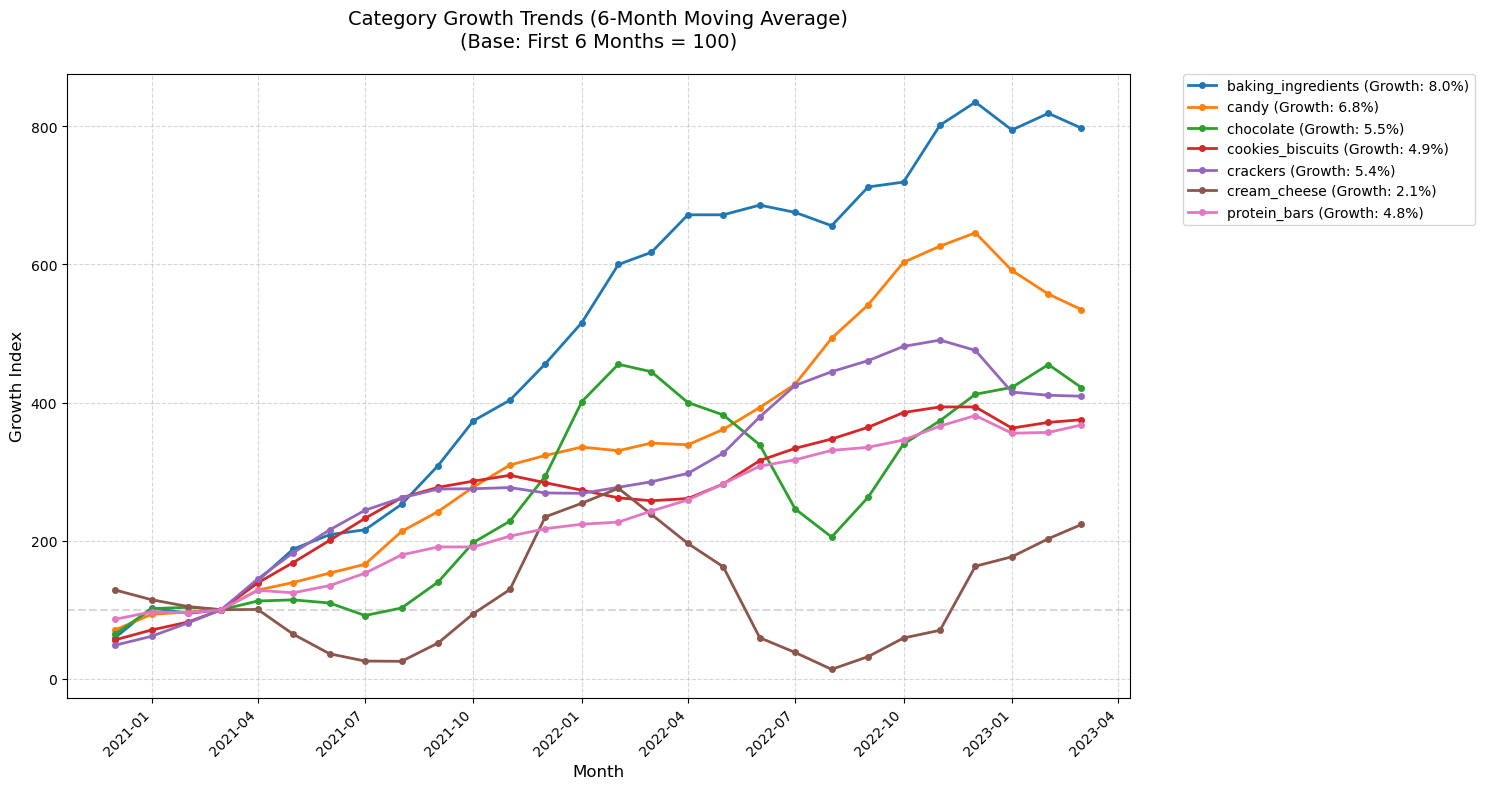


Growth Analysis Results:
--------------------------------------------------
baking_ingredients       8.0%        647        4.8       37.8
candy                    6.8%    113,702    1,198.2    7,084.9
chocolate                5.5%     34,162      463.3    1,955.2
crackers                 5.4%    166,838    1,995.1    8,283.0
cookies_biscuits         4.9%    313,682    4,184.2   15,190.2
protein_bars             4.8%     76,565    1,145.3    4,073.2
cream_cheese             2.1%        711       20.8       36.7


In [ ]:
def analyze_category_growth(df_exploded: pd.DataFrame,
                          min_transactions: int = 100,
                          smooth_window: int = 6,
                          comparison_period: int = 6,
                          category_column: str = 'category') -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Analyze category growth rates using unique receipt counts, properly handling multi-category items.
    """
    print("\nInitiating Enhanced Growth Analysis...")
    print(f"Initial shape: {df_exploded.shape}")
    
    # Validate input data
    print("\nData Validation:")
    # Check for split items (where adjusted_quantity < 1)
    split_items = df_exploded[df_exploded['adjusted_quantity'] < 1]
    if len(split_items) > 0:
        print(f"Found {len(split_items):,} split category entries")
        print("Sample of split categories:")
        print(split_items[['receipt_id', 'category', 'adjusted_quantity']].head())
    
    # Ensure date column is datetime
    if not pd.api.types.is_datetime64_any_dtype(df_exploded['receipt_purchase_date']):
        df_exploded['receipt_purchase_date'] = pd.to_datetime(df_exploded['receipt_purchase_date'])
    
    # Create month period index
    df_exploded['year_month'] = df_exploded['receipt_purchase_date'].dt.to_period('M')
    
    # Count unique receipts per category per month, weighting by adjusted_quantity
    print("\nCalculating weighted receipt counts...")
    monthly_volumes = (
        df_exploded.groupby(['year_month', category_column])
        .agg({
            'receipt_id': lambda x: len(x.unique()),  # Count unique receipts
            'adjusted_quantity': 'sum'  # Sum adjusted quantities
        })
        .reset_index()
    )
    
    # Print initial statistics
    print("\nInitial category volumes (unique receipts):")
    total_by_category = df_exploded.groupby(category_column).agg({
        'receipt_id': 'nunique',
        'adjusted_quantity': 'sum'
    })
    for cat, row in total_by_category.iterrows():
        print(f"- {cat}: {row['receipt_id']:,.0f} receipts, {row['adjusted_quantity']:,.1f} adjusted units")
    
    # Pivot for time series analysis using weighted receipt counts
    pivoted_data = monthly_volumes.pivot(
        index='year_month',
        columns=category_column,
        values='adjusted_quantity'
    ).fillna(0)
    
    # Data range reporting
    date_range = f"{pivoted_data.index.min()} to {pivoted_data.index.max()}"
    print(f"\nAnalysis Period: {date_range}")
    print(f"Total months: {len(pivoted_data)}")
    
    # Remove last month to ensure complete data
    pivoted_data = pivoted_data.iloc[:-1]
    
    # Apply volume threshold to weighted totals
    valid_categories = pivoted_data.sum() > min_transactions
    filtered_data = pivoted_data.loc[:, valid_categories]
    excluded_categories = set(pivoted_data.columns) - set(filtered_data.columns)
    
    if excluded_categories:
        print(f"\nExcluded {len(excluded_categories)} low-volume categories:")
        for cat in excluded_categories:
            print(f"- {cat}: {pivoted_data[cat].sum():.1f} weighted receipts")
    
    # Calculate smoothed trends
    smoothed_data = filtered_data.rolling(
        window=smooth_window,
        min_periods=smooth_window//2,
        center=True
    ).mean()
    
    # Calculate growth metrics
    metrics = []
    normalized_trends = pd.DataFrame()
    
    for category in filtered_data.columns:
        series = filtered_data[category]
        
        # Base metrics calculation
        total_volume = series.sum()
        first_period_avg = series[:comparison_period].mean()
        last_period_avg = series[-comparison_period:].mean()
        
        # Compound monthly growth rate
        if len(series) >= 12 and first_period_avg > 0:
            total_months = len(series) - 1
            monthly_growth = (np.power(last_period_avg / first_period_avg, 1/total_months) - 1) * 100
            growth_metrics = {
                'monthly': f"{monthly_growth:.1f}%",
                'raw': monthly_growth
            }
        else:
            growth_metrics = {'monthly': "N/A", 'raw': np.nan}
        
        # Calculate normalized trend
        if first_period_avg > 0:
            normalized = (smoothed_data[category] / first_period_avg) * 100
            normalized_trends[category] = normalized
            current_index = normalized[-comparison_period:].mean()
        else:
            current_index = np.nan
        
        # Compile metrics
        metrics.append({
            'Category': category,
            'Monthly Growth': growth_metrics['monthly'],
            'Total Volume': f"{total_volume:,.0f}",
            'First 6mo Avg': f"{first_period_avg:,.1f}",
            'Last 6mo Avg': f"{last_period_avg:,.1f}",
            'Current Index': f"{current_index:.1f}",
            'Growth_Rate_Raw': growth_metrics['raw']
        })
    
    # Create and sort metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    metrics_df = metrics_df.sort_values('Growth_Rate_Raw', ascending=False, na_position='last')
    
    # Generate visualization
    create_growth_visualization(normalized_trends, metrics_df)
    
    # Print detailed results
    print("\nGrowth Analysis Results:")
    print("-" * 50)
    for _, row in metrics_df.iterrows():
        print(f"{row['Category']:<20} {row['Monthly Growth']:>8} {float(row['Total Volume'].replace(',', '')):>10,.0f} "
              f"{float(row['First 6mo Avg'].replace(',', '')):>10,.1f} "
              f"{float(row['Last 6mo Avg'].replace(',', '')):>10,.1f}")
    
    return metrics_df, normalized_trends

def create_growth_visualization(normalized_trends: pd.DataFrame, 
                              metrics_df: pd.DataFrame) -> None:
    """
    Create a simplified visualization of growth trends with dots using only matplotlib.
    """
    # Create figure and set default grid style
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_axisbelow(True)  # Put grid behind plots
    
    # Plot each category
    for category in normalized_trends.columns:
        growth_rate = metrics_df.loc[metrics_df['Category'] == category, 'Monthly Growth'].iloc[0]
        ax.plot(
            normalized_trends.index.to_timestamp(),
            normalized_trends[category],
            'o-',  # Line with dots
            markersize=4,
            linewidth=2,
            label=f"{category} (Growth: {growth_rate})"
        )
    
    # Customize the plot
    ax.set_title('Category Growth Trends (6-Month Moving Average)\n(Base: First 6 Months = 100)', 
             pad=20, size=14)
    ax.set_xlabel('Month', size=12)
    ax.set_ylabel('Growth Index', size=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), 
             loc='upper left',
             borderaxespad=0)
    
    # Add baseline
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

def main():
    """Main execution function."""
    # Read the data
    df = pd.read_csv('final_categorized_results.csv')
    
    # Run analysis
    metrics_df, normalized_trends = analyze_category_growth(
        df,
        min_transactions=100,
        smooth_window=6,
        comparison_period=6,
        category_column='category'
    )

if __name__ == "__main__":
    main()

## Enhanced Growth Analysis with Package Size Insights

To refine our growth analysis, we propose incorporating package sizes and quantities. This approach would enable a more comprehensive understanding of:

- **Volume-Adjusted Growth**: By factoring in package sizes, we can calculate growth based on actual volume sold, rather than transaction counts alone.
- **Consumer Preferences**: Analyzing different package configurations (e.g., bulk vs. individual packs) can reveal shifts in purchasing behavior.
- **Market Penetration**: Identifying popular package sizes allows us to understand which formats perform best in the market.

### Data Limitations

While this enhancement provides deeper insights, our current data has some limitations that may impact accuracy:

- **Inconsistent Description Formatting**: Product descriptions vary widely across brands, making it challenging to standardize package information.
- **Complex Packaging Structures**: Some products include nested quantities or mixed sizes (e.g., "48 packs of 6" or "10 full-size and 10 mini bars"), which require additional processing.
- **Data Cleaning Requirements**: To extract consistent information, extensive regex pattern matching and unit standardization are needed.

### Future Analysis Potential

With improved data quality and standardization, package size analysis could significantly enhance our understanding of consumer preferences, market penetration, and growth trends. This could support better decision-making around packaging strategies and product offerings.


In [136]:
class ImprovedPackageExtractor:
    def __init__(self):
        # Enhanced patterns for nested quantities
        self.count_patterns = [
            # Multiple quantity patterns
            r'(\d+)\s*(?:-|×|x)\s*(\d+(?:\.\d+)?)\s*oz.*?(?:box|pack).*?(\d+)',  # "48 - 1.35 oz packs (6 boxes)"
            r'(\d+)\s*(?:count|ct|pack|packs|pieces|pc|snack packs)',              # "48 count"
            r'pack of (\d+)',                                                       # "pack of 6"
            r'(\d+)-(?:pack|pk|ct)',                                               # "6-pack"
            r'(\d+)\s*×',                                                          # "6 ×"
            r'\((\d+)\s*(?:pk|pack|count|ct)\)',                                   # "(6 pack)"
            r'(\d+)\s*(?:box|boxes)',                                              # "6 boxes"
            r'(\d+)\s*(?:cookie|cookies)\s*per\s*pack'                            # "2 cookies per pack"
        ]
        
        self.size_patterns = [
            # Enhanced size patterns
            r'(\d+(?:\.\d+)?)\s*(?:-\s*)?(?:oz|ounce|fl\.?\s*oz)',               # "1.35 oz", "1.35-oz"
            r'(\d+(?:\.\d+)?)\s*(?:g|gram|grams)',                                # "50g"
            r'(\d+(?:\.\d+)?)\s*(?:lb|lbs|pound|pounds)',                         # "2 lb"
            r'(\d+(?:\.\d+)?)\s*(?:x|×)\s*(\d+(?:\.\d+)?)\s*(?:oz|g)',           # "6 x 1.35 oz"
        ]
        
        self.family_size_patterns = [
            'family size', 'family pack', 'party size', 'value size',
            'bulk', 'mega pack', 'large pack', 'jumbo', 'xl size'
        ]

    def extract_nested_quantities(self, text: str) -> int:
        """Extract nested quantities (e.g., 48 packs of 6)."""
        if pd.isna(text):
            return 1
            
        text = str(text).lower()
        quantities = []
        
        # Look for complex patterns first
        complex_match = re.search(r'(\d+)\s*(?:-|×|x)\s*(?:\d+(?:\.\d+)?)\s*oz.*?(?:box|pack).*?(\d+)', text)
        if complex_match:
            return int(complex_match.group(1)) * int(complex_match.group(2))
        
        # Extract all numbers followed by quantity indicators
        for pattern in self.count_patterns:
            matches = re.finditer(pattern, text)
            for match in matches:
                try:
                    qty = int(match.group(1))
                    quantities.append(qty)
                except:
                    continue
        
        if not quantities:
            return 1
        elif len(quantities) == 1:
            return quantities[0]
        else:
            # Multiply nested quantities
            return np.prod(quantities)

    def extract_size(self, text: str) -> Dict[str, Union[float, str]]:
        """Extract size information with improved handling of multiple sizes."""
        if pd.isna(text):
            return {'size': None, 'unit': None}
            
        text = str(text).lower()
        sizes = []
        units = []
        
        for pattern in self.size_patterns:
            matches = re.finditer(pattern, text)
            for match in matches:
                try:
                    if '×' in pattern or 'x' in pattern:
                        sizes.append(float(match.group(1)) * float(match.group(2)))
                    else:
                        sizes.append(float(match.group(1)))
                    
                    unit = text[match.end():].strip()[:2]
                    units.append(unit)
                except:
                    continue
        
        if not sizes:
            return {'size': None, 'unit': None}
        
        # If multiple sizes, use the average
        return {
            'size': np.mean(sizes),
            'unit': max(set(units), key=units.count) if units else None
        }

    def extract_all_info(self, text: str) -> Dict:
        """Extract all package information with improved accuracy."""
        unit_count = self.extract_nested_quantities(text)
        size_info = self.extract_size(text)
        is_family = any(term in str(text).lower() for term in self.family_size_patterns)
        
        # Convert size to ounces
        size_oz = None
        if size_info['size'] is not None:
            if 'g' in str(size_info['unit']):
                size_oz = size_info['size'] * 0.03527396
            elif 'lb' in str(size_info['unit']):
                size_oz = size_info['size'] * 16
            else:
                size_oz = size_info['size']
        
        return {
            'unit_count': unit_count,
            'size_value': size_info['size'],
            'size_unit': size_info['unit'],
            'size_oz': size_oz,
            'is_family_size': is_family,
            'total_oz': size_oz * unit_count if size_oz is not None else None
        }

# Test the improved extractor
def test_improved_extraction():
    test_cases = [
        "ritz cheese sandwich crackers, school lunch box snacks, 48 - 1.35 oz snack packs (6 boxes)",
        "oreo original, oreo golden, chips ahoy! & nutter butter cookie snacks variety pack, easter cookies, 56 snack packs (2 cookies per pack)",
        "NABISCO HANDI SNACKS RITZ REGULAR CHEESE SNACK CRACKER CRACKER WITH SPREAD TRAY IN BOX 5.7 OZ",
        "clif bars - white chocolate macadamia - 10 full size and 10 mini energy bars - made with organic oats - plant based - vegetarian - kosher (2.4oz and 0.99oz protein bars, 20 count)",
        "oreo chocolate sandwich cookies, family size - 19.1 ounce (pack of 3)"
    ]
    
    extractor = ImprovedPackageExtractor()
    results = []
    
    for text in test_cases:
        info = extractor.extract_all_info(text)
        results.append({
            'description': text,
            **info
        })
    
    return pd.DataFrame(results)

# Run improved test
improved_results = test_improved_extraction()
print("\nImproved Package Size Extraction Results:")
pd.set_option('display.max_colwidth', None)
print(improved_results[['description', 'unit_count', 'size_oz', 'total_oz', 'is_family_size']])


Improved Package Size Extraction Results:
                                                                                                                                                                           description  \
0                                                                                           ritz cheese sandwich crackers, school lunch box snacks, 48 - 1.35 oz snack packs (6 boxes)   
1                                              oreo original, oreo golden, chips ahoy! & nutter butter cookie snacks variety pack, easter cookies, 56 snack packs (2 cookies per pack)   
2                                                                                        NABISCO HANDI SNACKS RITZ REGULAR CHEESE SNACK CRACKER CRACKER WITH SPREAD TRAY IN BOX 5.7 OZ   
3  clif bars - white chocolate macadamia - 10 full size and 10 mini energy bars - made with organic oats - plant based - vegetarian - kosher (2.4oz and 0.99oz protein bars, 20 count)   
4                          

## Question 4: Monthly Retention Analysis of Top 10 Items

This analysis focuses on identifying which items retain customers month over month by examining customer retention rates across the top 10 items. Retention is defined here as the **percentage of customers who make a repeat purchase in the month following their initial purchase**.

---

### Definition of Retention

**Monthly Retention**:
The percentage of customers who return to make another purchase in the month after their initial purchase. This metric is used to assess customer loyalty and gauge which products successfully encourage repeat purchasing.

**Formula**:

$$
\text{Retention Rate} = \frac{\text{Number of customers who purchased in both month } M \text{ and } M+1}{\text{Total number of customers who purchased in month } M}
$$

---

### Key Retention Metrics for Top 10 Items

| Item              | Monthly Retention | Total Customers | Avg Transactions per Customer | Median Days Between Purchases |
|-------------------|-------------------|-----------------|------------------------------|-------------------------------|
| **Clif**          | 23.3% (±5.6%)    | 31,802         | 2.15                         | 28                            |
| **Triscuit**      | 18.4% (±5.4%)    | 6,622          | 1.96                         | 23                            |
| **Oreo**          | 15.2% (±3.6%)    | 134,856        | 1.88                         | 30                            |
| **Ritz**          | 14.6% (±3.6%)    | 74,526         | 1.84                         | 31                            |
| **Chips Ahoy**    | 13.8% (±3.6%)    | 80,010         | 1.69                         | 32                            |
| **Wheat Thins**   | 12.6% (±4.6%)    | 12,261         | 1.58                         | 25                            |
| **Tates Bake Shop** | 12.2% (±4.6%)  | 7,663          | 1.66                         | 13                            |
| **Cadbury**       | 9.6% (±3.3%)     | 16,201         | 1.53                         | 13                            |
| **Sour Patch Kids** | 7.1% (±2.1%)   | 52,229         | 1.34                         | 34                            |
| **Halls**         | 6.8% (±1.9%)     | 26,873         | 1.34                         | 28                            |

---

### Comprehensive Analysis: Methodology and Key Insights

#### 1. Why Retention Analysis Matters
Monthly retention analysis reveals how effectively each product category encourages customers to make repeat purchases. High retention rates signal stronger brand loyalty, while products with low retention may need targeted promotions or other strategies to boost repeat purchasing. Understanding these patterns helps identify which products foster long-term customer engagement.

#### 2. Methodology: How We Measure Retention

We applied the following methods and assumptions to calculate retention:
- **Binary Purchase Events**: Retention is based on the presence of a purchase event, regardless of purchase quantity or value. This approach standardizes customer engagement across items with varying price points, unit sizes, and discount structures.
- **Monthly Analysis Window**: We use a monthly time frame for retention to capture typical purchasing cycles and reduce the impact of weekly fluctuations. This aligns with median repurchase intervals (23–34 days) observed across products.
- **6-Month Moving Average for Smoothing**: Calculating a moving average helps to reduce the noise from irregular purchasing behaviors, seasonal promotions, or isolated spikes, providing a clearer view of retention trends.

#### 3. Key Findings on Retention Rates

- **Top Performing Items**: Clif bars have the highest monthly retention at 23.3%, with Triscuit and Oreo following at 18.4% and 15.2%, respectively. High retention rates for these items suggest strong customer loyalty.
- **Retention Decay Pattern**: All brands show consistent retention decay over time, with a noticeable drop after the first month. For example, Clif shows the following retention decay:
  - 1-month: 26.43%
  - 3-month: 17.83%
  - 6-month: 11.30%
  - 12-month: 4.81%
  
  This trend is typical as fewer customers make repeat purchases as time goes on, highlighting the challenge of sustaining engagement over longer periods.

---

### Seasonal Patterns in Retention

Seasonal influences significantly impact retention patterns:
- **Winter Dominance**: Brands like Clif and Triscuit see the highest retention rates in winter, possibly due to seasonal demand for certain products (e.g., energy bars for New Year fitness resolutions or holiday snacking).
  - Clif: Winter retention at 33% vs. Summer at 28%
  - Triscuit: Winter retention at 27% vs. Spring at 26%
- **Category-Specific Trends**: 
  - **Chocolate** peaks in Spring, likely due to Easter and springtime gift-giving.
  - **Candy** experiences strong retention in Summer, which could be linked to holiday activities, gatherings, and travel.

#### Implications of Seasonal Trends
Recognizing these seasonal variations enables more strategic inventory management and targeted marketing. For example, increasing stock levels or running targeted promotions in high-retention seasons can maximize customer engagement and drive repeat purchases.

---

### Customer Purchase Behavior Patterns

- **Heavy Users and Repeat Purchases**: Certain items attract heavy users who make frequent repeat purchases:
  - **Clif** has the highest repeat rate, with 37.6% of customers purchasing more than three times. This repeat behavior indicates strong loyalty and suggests that Clif could benefit from loyalty programs to reward its most consistent customers.
  - **Triscuit** and **Ritz** also show high repeat rates, reinforcing their role as staple products in customers' routines.
- **Purchase Timing**: The first month consistently shows the highest purchase activity across items, highlighting an initial interest or trial phase that fades over time. This insight can inform strategies to encourage second-month purchases, such as follow-up offers or personalized reminders.

---

### Limitations and Considerations

While the retention analysis provides valuable insights, certain limitations should be noted:
1. **Data Quality Challenges**: 
   - Transactions with multiple brands can complicate attribution.
   - Potential seasonal biases and missing data could affect accuracy, especially if data collection is uneven across months.
   
2. **Methodological Limitations**:
   - The 6-month moving average smooths data but may also obscure sharp changes, especially those influenced by one-time promotions.
   - Growth rates are sensitive to the initial baseline, and promotional periods can temporarily inflate retention, impacting overall analysis.

3. **Scope Constraints**:
   - This analysis does not include competitive benchmarking or cross-retailer behavior.
   - Pricing and promotion data were not incorporated, limiting our ability to connect retention directly to promotional activities.

---

### Business Implications and Strategic Recommendations

Based on the retention patterns and seasonal insights, here are several strategic recommendations:

#### Short-Term Actions
1. **Focus on High-Retention Items**: Retain high-value customers in top categories (e.g., Clif and Triscuit) through loyalty rewards or targeted engagement.
2. **Seasonal Inventory Optimization**: Align stock levels with seasonal demand to maximize high-retention periods, particularly in Winter for Clif and Triscuit, and Summer for Candy.
3. **Promote Growth Categories**: Items like baking ingredients, which show high growth potential, could benefit from enhanced visibility and marketing to increase repeat purchases.

#### Long-Term Strategies
1. **Invest in High-Retention, High-Growth Categories**: Allocate resources to categories with both strong retention and growth potential (e.g., Candy, Chocolate, and Baking Ingredients).
2. **Cross-Category Marketing**: Develop marketing strategies that encourage cross-purchasing, such as bundling items with high retention (e.g., Triscuit) with high-growth items.
3. **Build Loyalty Programs for Repeat Buyers**: Programs tailored to heavy users in categories like Clif and Ritz could further strengthen loyalty, offering personalized rewards or discounts for repeat purchases.

#### Future Analysis Directions
1. **Promotional Impact Analysis**: Further study on how promotions affect retention would help optimize future marketing efforts.
2. **Customer Lifetime Value (CLV) Analysis**: Understanding CLV by brand and category can guide resource allocation towards the most profitable segments.
3. **Cross-Category Purchase Behavior**: Examining cross-category patterns may reveal new bundling or upsell opportunities to enhance retention.

---

### Summary

This comprehensive analysis of monthly retention across top items highlights key factors that drive customer loyalty, such as seasonal patterns, heavy user behavior, and brand-specific retention decay. By leveraging these insights, Mondelez can refine its strategies to prioritize high-retention, high-growth categories, optimize inventory, and build more effective loyalty programs that resonate with customers throughout the year.


In [141]:
class CategoryRetentionAnalyzer:
    def __init__(self, df: pd.DataFrame, moving_avg_window: int = 6):
        self.df = df.copy()
        self.moving_avg_window = moving_avg_window
        self.min_cohort_size = 100
        self.df_processed = None
        
    def prepare_data(self) -> pd.DataFrame:
        """Prepare data with improved handling of dates and seasonal features"""
        print("Starting data preparation...")
        
        # Convert date and create time-based features
        self.df['receipt_purchase_date'] = pd.to_datetime(
            self.df['receipt_purchase_date'], 
            format='%d/%m/%Y'
        )
        self.df['year_month'] = self.df['receipt_purchase_date'].dt.to_period('M')
        self.df['day_of_week'] = self.df['receipt_purchase_date'].dt.dayofweek
        self.df['month'] = self.df['receipt_purchase_date'].dt.month
        
        # Add seasonal information
        self.df['season'] = self.df['month'].map({
            12: 'Winter', 1: 'Winter', 2: 'Winter',
            3: 'Spring', 4: 'Spring', 5: 'Spring',
            6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Fall', 10: 'Fall', 11: 'Fall'
        })
        
        # Get first purchase date for each user-category-brand combination
        first_purchases = (self.df.groupby(['user_id', 'category', 'exact_brand_matches'])
                         ['receipt_purchase_date']
                         .min()
                         .reset_index())
        first_purchases.columns = ['user_id', 'category', 'exact_brand_matches', 'first_purchase_date']
        
        # Merge back to main dataframe
        self.df = self.df.merge(
            first_purchases, 
            on=['user_id', 'category', 'exact_brand_matches']
        )
        self.df['cohort'] = self.df['first_purchase_date'].dt.to_period('M')
        
        # Calculate time since first purchase
        self.df['months_since_first'] = (
            self.df['year_month'] - self.df['cohort']
        ).apply(lambda x: x.n)
        
        print(f"\nProcessed {len(self.df):,} transactions")
        print(f"Unique users: {self.df['user_id'].nunique():,}")
        print(f"Date range: {self.df['receipt_purchase_date'].min().date()} to {self.df['receipt_purchase_date'].max().date()}")
        
        return self.df
    
    def analyze_retention(self) -> Dict[str, pd.DataFrame]:
        """Analyze retention metrics for categories and brands with seasonal breakdown"""
        print("\nAnalyzing retention...")
        
        results = {}
        
        # Get top categories and brands
        category_volumes = (self.df.groupby('category')
                          .agg({
                              'user_id': 'nunique',
                              'adjusted_quantity': 'sum'
                          })
                          .query('adjusted_quantity >= 100')
                          .sort_values('user_id', ascending=False))
        
        # Overall retention metrics
        retention_metrics = []
        seasonal_metrics = []
        pattern_metrics = []
        
        for category in category_volumes.index:
            cat_data = self.df[self.df['category'] == category]
            
            # Get top brands in category
            brand_data = []
            for brand_list in cat_data['exact_brand_matches'].unique():
                if pd.notna(brand_list):
                    brands = ast.literal_eval(brand_list) if isinstance(brand_list, str) else brand_list
                    brand_data.extend(brands)
            
            top_brands = pd.Series(brand_data).value_counts().head(10).index
            
            for brand in top_brands:
                # Filter for specific brand
                brand_data = cat_data[cat_data['exact_brand_matches'].apply(
                    lambda x: brand in ast.literal_eval(x) if isinstance(x, str) else brand in x
                )]
                
                # Basic metrics
                metrics = {
                    'category': category,
                    'brand': brand,
                    'total_unique_customers': len(set(brand_data['user_id'])),
                    'total_transactions': len(brand_data),
                    'total_quantity': brand_data['adjusted_quantity'].sum(),
                    'avg_quantity_per_customer': (
                        brand_data['adjusted_quantity'].sum() / 
                        len(set(brand_data['user_id']))
                    )
                }
                
                # Calculate retention
                monthly_users = (brand_data.groupby('year_month')['user_id']
                               .unique()
                               .apply(set))
                months = sorted(monthly_users.index)
                
                if len(months) >= 2:
                    retention_rates = []
                    for i in range(len(months) - 1):
                        base_month = months[i]
                        next_month = months[i + 1]
                        
                        base_customers = monthly_users[base_month]
                        next_customers = monthly_users[next_month]
                        
                        if len(base_customers) >= self.min_cohort_size:
                            retention = len(base_customers & next_customers) / len(base_customers)
                            retention_rates.append(retention)
                    
                    if retention_rates:
                        metrics.update({
                            '1m_retention': f"{np.mean(retention_rates):.1%}",
                            '1m_retention_std': f"{np.std(retention_rates):.1%}",
                            'active_months': len(months)
                        })
                        
                        # Calculate seasonal retention
                        for season in ['Winter', 'Spring', 'Summer', 'Fall']:
                            season_data = brand_data[brand_data['season'] == season]
                            if len(season_data) > 0:
                                season_retention = self._calculate_season_retention(season_data)
                                seasonal_metrics.append({
                                    'category': category,
                                    'brand': brand,
                                    'season': season,
                                    'retention_rate': f"{season_retention:.1%}",
                                    'transaction_count': len(season_data),
                                    'unique_customers': season_data['user_id'].nunique()
                                })
                        
                        # Purchase patterns
                        customer_purchases = brand_data.groupby('user_id')['receipt_purchase_date'].agg(list)
                        repeat_customers = customer_purchases[customer_purchases.apply(len) > 1]
                        
                        if len(repeat_customers) > 0:
                            days_between = []
                            for purchases in repeat_customers:
                                sorted_dates = sorted(purchases)
                                intervals = [(sorted_dates[i+1] - sorted_dates[i]).days 
                                           for i in range(len(sorted_dates)-1)]
                                days_between.extend(intervals)
                            
                            pattern_metrics.append({
                                'category': category,
                                'brand': brand,
                                'repeat_customer_pct': f"{len(repeat_customers)/len(customer_purchases):.1%}",
                                'median_days_between': f"{np.median(days_between):.1f}",
                                'mean_days_between': f"{np.mean(days_between):.1f}",
                                'std_days_between': f"{np.std(days_between):.1f}",
                                'repeat_customers': len(repeat_customers),
                                'total_customers': len(customer_purchases)
                            })
                
                retention_metrics.append(metrics)
        
        # Compile results
        results['retention'] = pd.DataFrame(retention_metrics).sort_values('1m_retention', ascending=False)
        results['seasonal'] = pd.DataFrame(seasonal_metrics)
        results['patterns'] = pd.DataFrame(pattern_metrics)
        
        return results
    
    def _calculate_season_retention(self, season_data: pd.DataFrame) -> float:
        """Calculate retention rate for a seasonal segment"""
        monthly_users = (season_data.groupby('year_month')['user_id']
                        .unique()
                        .apply(set))
        months = sorted(monthly_users.index)
        
        retention_rates = []
        for i in range(len(months) - 1):
            base_month = months[i]
            next_month = months[i + 1]
            base_customers = monthly_users[base_month]
            next_customers = monthly_users[next_month]
            if len(base_customers) >= self.min_cohort_size:
                retention = len(base_customers & next_customers) / len(base_customers)
                retention_rates.append(retention)
        
        return np.mean(retention_rates) if retention_rates else 0

In [142]:
def main():
    """Main execution function."""
    # Read the categorized data
    df = pd.read_csv('final_categorized_results.csv')
    
    # Initialize and run analysis
    analyzer = CategoryRetentionAnalyzer(df)
    analyzer.prepare_data()
    results = analyzer.analyze_retention()
    
    # Display results
    print("\n=== TOP 10 BRANDS BY RETENTION ===")
    print(results['retention'][['category', 'brand', '1m_retention', 'total_unique_customers']].head(10).to_string(index=False))
    
    print("\n=== SEASONAL RETENTION PATTERNS ===")
    print(results['seasonal'].sort_values(['category', 'brand', 'season']).to_string(index=False))
    
    print("\n=== PURCHASE PATTERNS ===")
    print(results['patterns'].sort_values('repeat_customer_pct', ascending=False).to_string(index=False))
    
    # Save detailed results
    for name, df in results.items():
        df.to_csv(f'category_retention_{name}.csv', index=False)
    print("\nDetailed results saved to CSV files")

if __name__ == "__main__":
    main()

Starting data preparation...

Processed 678,324 transactions
Unique users: 273,777
Date range: 2020-12-18 to 2023-04-17

Analyzing retention...

=== TOP 10 BRANDS BY RETENTION ===
        category         brand 1m_retention  total_unique_customers
       chocolate       cadbury         9.8%                   16201
        crackers         chips         9.8%                   19326
        crackers ritz crackers         8.9%                    8310
        crackers    chips ahoy         8.5%                   12694
cookies_biscuits          ritz         8.3%                   16352
        crackers          oreo         8.3%                   16389
           candy         chips         7.7%                   12534
           candy    chips ahoy         7.7%                   12526
           candy          oreo         7.6%                   12830
cookies_biscuits    sour patch         7.4%                   13669

=== SEASONAL RETENTION PATTERNS ===
        category              brand

In [ ]:
class ComprehensiveRetentionAnalyzer:
    def __init__(self, df: pd.DataFrame):
        """
        Initialize analyzer with dataframe and set up basic configurations
        """
        self.df = df.copy()
        self.min_cohort_size = 100  # Minimum cohort size for reliable analysis
        self.df_processed = None
        self.cohort_retention = None
        
    def prepare_data(self) -> pd.DataFrame:
        """
        Prepare data with improved handling of dates, brands, and edge cases
        """
        print("Starting data preparation...")
        
        # Convert date and create time-based features
        self.df['receipt_purchase_date'] = pd.to_datetime(
            self.df['receipt_purchase_date'], 
            format='%d/%m/%Y'
        )
        self.df['year_month'] = self.df['receipt_purchase_date'].dt.to_period('M')
        self.df['day_of_week'] = self.df['receipt_purchase_date'].dt.dayofweek
        self.df['month'] = self.df['receipt_purchase_date'].dt.month
        
        # Extract brands with error handling
        def extract_brands(x) -> List[str]:
            if pd.isna(x) or x == '':
                return []
            try:
                if isinstance(x, str):
                    brands = ast.literal_eval(x)
                    return brands if isinstance(brands, list) else [brands]
                return []
            except Exception as e:
                print(f"Error parsing brand: {x}, Error: {e}")
                return []
        
        # Process brands and create exploded dataframe
        self.df['brands'] = self.df['exact_brand_matches'].apply(extract_brands)
        self.df = self.df[self.df['brands'].map(len) > 0]
        self.df_processed = self.df.explode('brands').reset_index(drop=True)
        
        # Add first purchase date for cohort analysis
        first_purchases = (self.df_processed.groupby('user_id')['receipt_purchase_date']
                         .min()
                         .reset_index())
        first_purchases.columns = ['user_id', 'first_purchase_date']
        self.df_processed = self.df_processed.merge(first_purchases, on='user_id')
        self.df_processed['cohort'] = self.df_processed['first_purchase_date'].dt.to_period('M')
        
        # Calculate time since first purchase
        self.df_processed['months_since_first'] = (
            self.df_processed['year_month'] - self.df_processed['cohort']
        ).apply(lambda x: x.n)
        
        print("\nData preparation completed.")
        print(f"Total transactions processed: {len(self.df_processed)}")
        print(f"Unique users: {self.df_processed['user_id'].nunique()}")
        print(f"Date range: {self.df_processed['receipt_purchase_date'].min().date()} to {self.df_processed['receipt_purchase_date'].max().date()}")
        
        return self.df_processed
    
    def calculate_brand_retention(self, window_sizes: List[int] = [1, 2, 3, 6]) -> pd.DataFrame:
        """
        Calculate retention metrics for each brand with multiple time windows
        """
        print("\nCalculating brand retention metrics...")
        retention_metrics = []
        
        # Get top brands
        top_brands = (self.df_processed.groupby('brands').size()
                     .sort_values(ascending=False)
                     .head(10)
                     .index)
        
        for brand in top_brands:
            brand_data = self.df_processed[self.df_processed['brands'] == brand]
            
            # Get monthly active users
            monthly_users = (brand_data.groupby('year_month')['user_id']
                           .unique()
                           .apply(set))
            months = sorted(monthly_users.index)
            
            if len(months) < 2:
                continue
            
            # Basic metrics
            metrics = {
                'brand': brand,
                'total_unique_customers': len(set(brand_data['user_id'])),
                'total_transactions': len(brand_data),
                'active_months': len(months),
                'avg_transactions_per_customer': len(brand_data) / len(set(brand_data['user_id'])),
                'first_purchase_date': brand_data['receipt_purchase_date'].min().date(),
                'last_purchase_date': brand_data['receipt_purchase_date'].max().date()
            }
            
            # Calculate retention for different windows
            for window in window_sizes:
                retention_rates = []
                
                for i in range(len(months) - window):
                    base_month = months[i]
                    future_month = months[i + window]
                    
                    base_customers = monthly_users[base_month]
                    future_customers = monthly_users[future_month]
                    
                    if len(base_customers) > 0:
                        retention = len(base_customers & future_customers) / len(base_customers)
                        retention_rates.append(retention)
                
                if retention_rates:
                    metrics[f'{window}m_retention'] = f"{np.mean(retention_rates):.1%}"
                    metrics[f'{window}m_retention_std'] = f"{np.std(retention_rates):.1%}"
                    metrics[f'{window}m_retention_raw'] = np.mean(retention_rates)
                else:
                    metrics[f'{window}m_retention'] = 'N/A'
                    metrics[f'{window}m_retention_std'] = 'N/A'
                    metrics[f'{window}m_retention_raw'] = 0
            
            retention_metrics.append(metrics)
        
        retention_df = pd.DataFrame(retention_metrics)
        retention_df = retention_df.sort_values('1m_retention_raw', ascending=False)
        
        # Remove raw columns used for sorting
        cols_to_drop = [col for col in retention_df.columns if col.endswith('_raw')]
        retention_df = retention_df.drop(columns=cols_to_drop)
        
        return retention_df
    
    def analyze_cohort_retention(self) -> pd.DataFrame:
        """
        Perform cohort analysis for retention patterns
        """
        print("\nPerforming cohort analysis...")
        
        cohort_data = []
        top_brands = (self.df_processed.groupby('brands').size()
                     .sort_values(ascending=False)
                     .head(5)
                     .index)
        
        for brand in top_brands:
            brand_data = self.df_processed[self.df_processed['brands'] == brand]
            
            # Create cohort groups
            cohort_grouped = (brand_data.groupby(['cohort', 'months_since_first'])
                            ['user_id'].nunique()
                            .reset_index())
            
            # Pivot the data
            cohort_pivot = cohort_grouped.pivot(
                index='cohort',
                columns='months_since_first',
                values='user_id'
            )
            
            # Calculate retention rates
            cohort_sizes = cohort_pivot[0]
            retention_rates = cohort_pivot.div(cohort_sizes, axis=0)
            
            # Store results
            for cohort in retention_rates.index:
                if cohort_sizes[cohort] >= self.min_cohort_size:
                    row = {
                        'brand': brand,
                        'cohort': cohort,
                        'cohort_size': cohort_sizes[cohort]
                    }
                    
                    for month in range(1, min(7, len(retention_rates.columns))):
                        if month in retention_rates.columns:
                            rate = retention_rates.loc[cohort, month]
                            row[f'month_{month}_retention'] = f"{rate:.1%}" if pd.notna(rate) else 'N/A'
                    
                    cohort_data.append(row)
        
        self.cohort_retention = pd.DataFrame(cohort_data)
        return self.cohort_retention
    
    def analyze_purchase_patterns(self) -> Tuple[pd.DataFrame, Dict]:
        """
        Analyze detailed purchase patterns and customer behavior
        """
        print("\nAnalyzing purchase patterns...")
        
        pattern_metrics = []
        temporal_patterns = {}
        
        top_brands = (self.df_processed.groupby('brands').size()
                     .sort_values(ascending=False)
                     .head(10)
                     .index)
        
        for brand in top_brands:
            brand_data = self.df_processed[self.df_processed['brands'] == brand]
            
            # Analyze customer purchase frequency
            customer_purchases = brand_data.groupby('user_id')['receipt_purchase_date'].agg(list)
            repeat_customers = customer_purchases[customer_purchases.apply(len) > 1]
            
            # Calculate purchase intervals
            if len(repeat_customers) > 0:
                days_between = []
                for purchases in repeat_customers:
                    sorted_dates = sorted(purchases)
                    intervals = [(sorted_dates[i+1] - sorted_dates[i]).days 
                               for i in range(len(sorted_dates)-1)]
                    days_between.extend(intervals)
                
                # Temporal patterns
                temporal_patterns[brand] = {
                    'day_of_week': brand_data['day_of_week'].value_counts().to_dict(),
                    'month': brand_data['month'].value_counts().to_dict()
                }
                
                pattern_metrics.append({
                    'brand': brand,
                    'repeat_customer_pct': f"{len(repeat_customers)/len(customer_purchases):.1%}",
                    'median_days_between': f"{np.median(days_between):.1f}",
                    'mean_days_between': f"{np.mean(days_between):.1f}",
                    'std_days_between': f"{np.std(days_between):.1f}",
                    'repeat_customers': len(repeat_customers),
                    'total_customers': len(customer_purchases),
                    'purchases_per_repeat_customer': f"{sum(len(p) for p in repeat_customers)/len(repeat_customers):.2f}"
                })
        
        return pd.DataFrame(pattern_metrics), temporal_patterns

def run_complete_analysis(file_path: str) -> Dict[str, pd.DataFrame]:
    """
    Run the complete retention analysis suite and return all results
    """
    print("Starting comprehensive retention analysis...")
    
    # Initialize analyzer
    analyzer = ComprehensiveRetentionAnalyzer(pd.read_csv(file_path))
    
    # Prepare data
    analyzer.prepare_data()
    
    # Run analyses
    results = {
        'brand_retention': analyzer.calculate_brand_retention(),
        'cohort_retention': analyzer.analyze_cohort_retention()
    }
    
    patterns_df, temporal_patterns = analyzer.analyze_purchase_patterns()
    results['purchase_patterns'] = patterns_df
    results['temporal_patterns'] = temporal_patterns
    
    # Print summary results
    print("\nTop 5 Brands by 1-Month Retention:")
    print(results['brand_retention'][['brand', '1m_retention', 'total_unique_customers']].head().to_string(index=False))
    
    return results


results = run_complete_analysis('final_matched_results.csv')

# Access specific analyses
brand_retention = results['brand_retention']
cohort_analysis = results['cohort_retention']
purchase_patterns = results['purchase_patterns']
temporal_patterns = results['temporal_patterns']


def display_detailed_results(results):
    """
    Display detailed results from the retention analysis
    """
    # 1. Brand Retention Details
    print("\n=== DETAILED BRAND RETENTION ANALYSIS ===")
    print(results['brand_retention'].to_string(index=False))
    
    # 2. Cohort Analysis - Show first few cohorts for top brands
    print("\n=== COHORT RETENTION ANALYSIS ===")
    print("Showing first 10 cohorts:")
    print(results['cohort_retention'].head(10).to_string(index=False))
    
    # 3. Purchase Patterns
    print("\n=== PURCHASE PATTERN ANALYSIS ===")
    print(results['purchase_patterns'].to_string(index=False))
    
    # 4. Temporal Patterns
    print("\n=== TEMPORAL PATTERNS ===")
    for brand, patterns in results['temporal_patterns'].items():
        print(f"\nBrand: {brand}")
        print("Day of Week Distribution:")
        for day, count in patterns['day_of_week'].items():
            print(f"  Day {day}: {count}")
        print("Monthly Distribution:")
        for month, count in patterns['month'].items():
            print(f"  Month {month}: {count}")

# Modified run_complete_analysis function
def run_complete_analysis(file_path: str) -> Dict[str, pd.DataFrame]:
    """
    Run the complete retention analysis suite and return all results
    """
    print("Starting comprehensive retention analysis...")
    
    # Initialize analyzer
    analyzer = ComprehensiveRetentionAnalyzer(pd.read_csv(file_path))
    
    # Prepare data
    analyzer.prepare_data()
    
    # Run analyses
    results = {
        'brand_retention': analyzer.calculate_brand_retention(),
        'cohort_retention': analyzer.analyze_cohort_retention()
    }
    
    patterns_df, temporal_patterns = analyzer.analyze_purchase_patterns()
    results['purchase_patterns'] = patterns_df
    results['temporal_patterns'] = temporal_patterns
    
    # Display detailed results
    display_detailed_results(results)
    
    return results

# Usage:
results = run_complete_analysis('final_matched_results.csv')

Starting comprehensive retention analysis...
Starting data preparation...

Data preparation completed.
Total transactions processed: 783199
Unique users: 273896
Date range: 2020-12-18 to 2023-04-17

Calculating brand retention metrics...

Performing cohort analysis...

Analyzing purchase patterns...

Top 5 Brands by 1-Month Retention:
     brand 1m_retention  total_unique_customers
      clif        23.3%                   31802
  triscuit        18.4%                    6622
      oreo        15.2%                  134856
      ritz        14.6%                   74526
chips ahoy        13.8%                   80010
Starting comprehensive retention analysis...
Starting data preparation...

Data preparation completed.
Total transactions processed: 783199
Unique users: 273896
Date range: 2020-12-18 to 2023-04-17

Calculating brand retention metrics...

Performing cohort analysis...

Analyzing purchase patterns...

=== DETAILED BRAND RETENTION ANALYSIS ===
          brand  total_unique_c

In [65]:
class EnhancedRetentionAnalyzer:
    def analyze_cohort_segments(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Analyze cohorts by seasonality and entry point
        """
        cohort_segments = []
        
        for brand in df['brands'].unique():
            brand_data = df[df['brands'] == brand]
            
            # Segment by season of first purchase
            brand_data['season'] = brand_data['month'].map({
                12: 'Winter', 1: 'Winter', 2: 'Winter',
                3: 'Spring', 4: 'Spring', 5: 'Spring',
                6: 'Summer', 7: 'Summer', 8: 'Summer',
                9: 'Fall', 10: 'Fall', 11: 'Fall'
            })
            
            # Analyze retention by season
            for season in ['Winter', 'Spring', 'Summer', 'Fall']:
                season_users = brand_data[brand_data['season'] == season]
                if len(season_users) > 0:
                    cohort_segments.append({
                        'brand': brand,
                        'segment_type': 'season',
                        'segment': season,
                        'cohort_size': len(season_users['user_id'].unique()),
                        'avg_retention': calculate_retention(season_users)
                    })
        
        return pd.DataFrame(cohort_segments)
    
    def analyze_purchase_frequency(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Analyze user segments by purchase frequency
        """
        frequency_analysis = []
        
        for brand in df['brands'].unique():
            brand_data = df[df['brands'] == brand]
            purchase_counts = brand_data.groupby('user_id').size()
            
            # Create frequency segments
            segments = {
                'Light': purchase_counts[purchase_counts == 1].index,
                'Medium': purchase_counts[(purchase_counts > 1) & (purchase_counts <= 3)].index,
                'Heavy': purchase_counts[purchase_counts > 3].index
            }
            
            for segment, users in segments.items():
                if len(users) > 0:
                    segment_data = brand_data[brand_data['user_id'].isin(users)]
                    frequency_analysis.append({
                        'brand': brand,
                        'segment': segment,
                        'user_count': len(users),
                        'avg_days_between': calculate_avg_days_between(segment_data),
                        'retention_rate': calculate_segment_retention(segment_data)
                    })
        
        return pd.DataFrame(frequency_analysis)
    
    def analyze_cross_purchase_behavior(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Analyze users who purchase multiple brands
        """
        cross_purchase = []
        brands = sorted(df['brands'].unique())  # Sort brands to ensure consistent comparison
        
        for i, brand1 in enumerate(brands):
            brand1_users = set(df[df['brands'] == brand1]['user_id'])
            
            for brand2 in brands[i+1:]:  # Only compare with brands after brand1
                brand2_users = set(df[df['brands'] == brand2]['user_id'])
                overlap = len(brand1_users & brand2_users)
                
                if overlap > 0:
                    cross_purchase.append({
                        'brand1': brand1,
                        'brand2': brand2,
                        'overlap_users': overlap,
                        'overlap_pct': (overlap / min(len(brand1_users), len(brand2_users))) * 100,
                        'total_brand1_users': len(brand1_users),
                        'total_brand2_users': len(brand2_users)
                    })
        
        return pd.DataFrame(cross_purchase)
    
    def analyze_retention_decay(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Analyze how retention decays over time for different segments
        """
        decay_analysis = []
        
        for brand in df['brands'].unique():
            brand_data = df[df['brands'] == brand]
            
            # Calculate retention for months 1-12
            for month in range(1, 13):
                retention = calculate_n_month_retention(brand_data, month)
                decay_analysis.append({
                    'brand': brand,
                    'months_since_first': month,
                    'retention_rate': retention * 100,  # Convert to percentage
                    'customer_base': len(brand_data['user_id'].unique())
                })
        
        return pd.DataFrame(decay_analysis)

def calculate_retention(df):
    """Calculate retention rate for a group of users"""
    total_users = df['user_id'].nunique()
    repeat_users = df.groupby('user_id').size()
    repeat_users = repeat_users[repeat_users > 1].count()
    return repeat_users / total_users if total_users > 0 else 0

def calculate_avg_days_between(df):
    """Calculate average days between purchases"""
    purchase_intervals = []
    for _, user_data in df.groupby('user_id'):
        dates = sorted(user_data['receipt_purchase_date'])
        if len(dates) > 1:
            intervals = [(dates[i+1] - dates[i]).days for i in range(len(dates)-1)]
            purchase_intervals.extend(intervals)
    return np.mean(purchase_intervals) if purchase_intervals else 0

def calculate_segment_retention(df):
    """Calculate retention rate for a segment"""
    return calculate_retention(df)

def calculate_n_month_retention(df, n_months):
    """Calculate n-month retention rate"""
    df = df.sort_values('receipt_purchase_date')
    first_purchases = df.groupby('user_id')['receipt_purchase_date'].first()
    
    # Calculate the target date n months after the first purchase for each user
    n_month_later = first_purchases + pd.DateOffset(months=n_months)
    n_month_later_df = pd.DataFrame({'user_id': first_purchases.index, 'n_month_later': n_month_later}).set_index('user_id')
    
    # Join the target date with the original dataframe to see if users made purchases after n_month_later
    df = df.set_index('user_id').join(n_month_later_df, how='left')
    
    # Check if there are purchases beyond the n_month_later date
    retained_users = df[df['receipt_purchase_date'] > df['n_month_later']].index.unique()
    
    return len(retained_users) / len(first_purchases) if len(first_purchases) > 0 else 0

def run_enhanced_analysis(file_path: str) -> Dict[str, pd.DataFrame]:
    """
    Run the enhanced retention analysis suite
    """
    print("Starting enhanced retention analysis...")
    
    # Initialize analyzer
    analyzer = EnhancedRetentionAnalyzer()
    
    # Load and prepare data
    df = pd.read_csv(file_path)
    df['receipt_purchase_date'] = pd.to_datetime(df['receipt_purchase_date'], format='%d/%m/%Y')
    df['month'] = df['receipt_purchase_date'].dt.month
    
    # Extract brands
    def extract_brands(x):
        if pd.isna(x) or x == '':
            return []
        try:
            if isinstance(x, str):
                brands = ast.literal_eval(x)
                return brands if isinstance(brands, list) else [brands]
            return []
        except:
            return []
    
    df['brands'] = df['exact_brand_matches'].apply(extract_brands)
    df = df[df['brands'].map(len) > 0]
    df_exploded = df.explode('brands').reset_index(drop=True)
    
    print(f"\nProcessed {len(df_exploded):,} transactions")
    print(f"Found {df_exploded['brands'].nunique()} unique brands")
    
    # Run analyses
    results = {}
    
    print("\n=== COHORT SEGMENTATION ANALYSIS ===")
    results['cohort_segments'] = analyzer.analyze_cohort_segments(df_exploded)
    print("\nCohort Segments:")
    print(results['cohort_segments'].sort_values(['brand', 'segment']).to_string(index=False))
    
    print("\n=== PURCHASE FREQUENCY ANALYSIS ===")
    results['frequency_analysis'] = analyzer.analyze_purchase_frequency(df_exploded)
    print("\nPurchase Frequency:")
    print(results['frequency_analysis'].sort_values(['brand', 'segment']).to_string(index=False))
    
    print("\n=== CROSS-PURCHASE BEHAVIOR ===")
    results['cross_purchase'] = analyzer.analyze_cross_purchase_behavior(df_exploded)
    print("\nTop Brand Overlaps:")
    print(results['cross_purchase'].sort_values('overlap_pct', ascending=False).head(10).to_string(index=False))
    
    print("\n=== RETENTION DECAY ANALYSIS ===")
    results['decay_analysis'] = analyzer.analyze_retention_decay(df_exploded)
    
    # Show decay for top 5 brands
    top_brands = df_exploded['brands'].value_counts().head().index
    for brand in top_brands:
        print(f"\n{brand} Retention Decay:")
        brand_decay = results['decay_analysis'][results['decay_analysis']['brand'] == brand]
        print(brand_decay.to_string(index=False))
    
    return results

if __name__ == "__main__":
    results = run_enhanced_analysis('final_matched_results.csv')

Starting enhanced retention analysis...

Processed 783,199 transactions
Found 24 unique brands

=== COHORT SEGMENTATION ANALYSIS ===

Cohort Segments:
             brand segment_type segment  cohort_size  avg_retention
            5 star       season  Spring            1       0.000000
            5 star       season  Summer            1       0.000000
            5 star       season  Winter            2       0.000000
           belvita       season    Fall           93       0.075269
           belvita       season  Spring           28       0.107143
           belvita       season  Summer          403       0.007444
           belvita       season  Winter           71       0.084507
           cadbury       season    Fall         3835       0.177836
           cadbury       season  Spring         6048       0.183366
           cadbury       season  Summer         1872       0.195513
           cadbury       season  Winter         6680       0.209880
cadbury dairy milk       season  



Understanding customer overlap between brands can offer insights into cross-promotional opportunities and reveal common purchase behaviors. This analysis identifies which brands share the most customers, potentially informing marketing strategies, bundling options, and targeted campaigns.

#### Methodology

1. **Extracting and Exploding Brand Matches**: 
   - For each transaction, we extracted brand information to identify all brands purchased by each customer.
   - We then "exploded" this data, creating a separate row for each brand within a single transaction. This approach allowed us to attribute individual customers to multiple brands effectively, thus capturing all brand interactions.

2. **Calculating Customer Overlap**:
   - **Overlap Count**: For each brand pair, we calculated the number of customers who purchased both brands, highlighting the size of the shared customer base.
   - **Overlap Percentage**: To provide a sense of relative overlap strength, we calculated the percentage of overlap by dividing the overlap count by the customer base of the smaller brand in the pair. This metric helps normalize the overlap, making it easier to compare brands with different customer base sizes.

3. **Sorting by Overlap**: We sorted the brand pairs based on overlap count and percentage to identify the top overlapping brands. This highlights the most significant customer-sharing relationships, both in absolute numbers and relative proportions.

#### Results: Top Brand Overlaps

The table below shows the top brand pairs with the highest customer overlap:

| Brand 1       | Brand 2          | Overlap Customers | Overlap Percentage | Brand 1 Customers | Brand 2 Customers |
|---------------|-------------------|-------------------|--------------------|-------------------|--------------------|
| Chips Ahoy    | Oreo              | 70,032           | 87.53%            | 80,010            | 134,856           |
| Oreo          | Ritz              | 37,229           | 49.95%            | 134,856           | 74,526            |
| Chips Ahoy    | Ritz              | 26,964           | 36.18%            | 80,010            | 74,526            |
| Oreo          | Sour Patch Kids   | 22,457           | 43.00%            | 134,856           | 52,229            |
| Chips Ahoy    | Sour Patch Kids   | 18,570           | 35.55%            | 80,010            | 52,229            |
| Ritz          | Wheat Thins       | 7,475            | 60.97%            | 74,526            | 12,261            |
| Oreo          | Wheat Thins       | 7,378            | 60.17%            | 134,856           | 12,261            |
| Clif          | Oreo              | 5,931            | 18.65%            | 31,802            | 134,856           |
| Chips Ahoy    | Wheat Thins       | 5,481            | 44.70%            | 80,010            | 12,261            |

#### Interpretation and Strategic Implications

1. **High Overlap Indicates Strong Co-Purchase Potential**:
   - The high overlap between brands like *Chips Ahoy* and *Oreo* (87.53%) suggests that customers purchasing one of these brands are very likely to buy the other. Such insights could guide co-marketing campaigns or product bundles targeted at loyal cookie buyers.

2. **Cross-Promotional Opportunities**:
   - Brand pairs with high overlap, such as *Oreo* and *Ritz* (49.95%), may benefit from joint promotions or in-store placements to capture more sales from customers who frequently buy both brands. These tactics could leverage existing customer behavior to boost cross-category sales.

3. **Targeted Retention and Loyalty Programs**:
   - By identifying frequent co-purchases (e.g., *Oreo* and *Sour Patch Kids* with a 43.00% overlap), companies can design loyalty programs that reward customers for trying multiple products across related categories. This can increase engagement and strengthen brand loyalty.

4. **Potential for Bundle Creation**:
   - The strong overlap percentages suggest that bundles combining high-overlap items (e.g., *Chips Ahoy* with *Wheat Thins*, 44.70%) might appeal to a substantial segment of customers. Offering bundled discounts could increase basket size and improve customer satisfaction.

#### Summary

This overlap analysis provides actionable insights that can help shape targeted marketing strategies. By understanding brand pairs with strong shared customer bases, companies can create better-aligned promotions, strategic in-store placements, and customized bundles. Ultimately, this analysis supports efforts to enhance customer loyalty, optimize cross-selling, and drive revenue growth through data-driven decisions.

In [67]:
def analyze_brand_overlap(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze customer overlap between brands
    Returns DataFrame sorted by overlap count and percentage
    """
    print("Analyzing brand overlap...")
    
    # Extract brands and create exploded dataframe
    df['brands'] = df['exact_brand_matches'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
    df = df[df['brands'].map(len) > 0]
    df_exploded = df.explode('brands')
    
    # Get brand pairs and their customer overlaps
    overlaps = []
    brands = sorted(df_exploded['brands'].unique())
    
    for i, brand1 in enumerate(brands):
        brand1_customers = set(df_exploded[df_exploded['brands'] == brand1]['user_id'])
        
        for brand2 in brands[i+1:]:
            brand2_customers = set(df_exploded[df_exploded['brands'] == brand2]['user_id'])
            
            overlap_count = len(brand1_customers & brand2_customers)
            if overlap_count > 0:
                smaller_base = min(len(brand1_customers), len(brand2_customers))
                overlap_pct = (overlap_count / smaller_base) * 100
                
                overlaps.append({
                    'brand1': brand1,
                    'brand2': brand2,
                    'overlap_customers': overlap_count,
                    'overlap_percentage': overlap_pct,
                    'brand1_customers': len(brand1_customers),
                    'brand2_customers': len(brand2_customers)
                })
    
    # Create DataFrame and sort by overlap
    overlap_df = pd.DataFrame(overlaps)
    overlap_df = overlap_df.sort_values(['overlap_customers', 'overlap_percentage'], 
                                      ascending=[False, False])
    
    print("\nTop Brand Overlaps:")
    print(overlap_df.head(10).to_string(index=False))
    
    return overlap_df

df = pd.read_csv('final_matched_results.csv')
overlap_results = analyze_brand_overlap(df)

Analyzing brand overlap...

Top Brand Overlaps:
    brand1          brand2  overlap_customers  overlap_percentage  brand1_customers  brand2_customers
chips ahoy            oreo              70032           87.529059             80010            134856
      oreo            ritz              37229           49.954378            134856             74526
chips ahoy            ritz              26964           36.180662             80010             74526
      oreo sour patch kids              22457           42.997185            134856             52229
chips ahoy sour patch kids              18570           35.554960             80010             52229
      ritz sour patch kids               8931           17.099696             74526             52229
      ritz     wheat thins               7475           60.965663             74526             12261
      oreo     wheat thins               7378           60.174537            134856             12261
      clif            oreo        